In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri

In [3]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy


# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../1_preprocess/'))
sys.path.append(os.path.abspath('../'))
from qc_plots import calculate_perturbed_gene_expression, test_knockdown_simple
from utils import feature_selection

In [4]:
# Load rpy2 magic for R integration in Python
%load_ext rpy2.ipython


In [6]:
%%R
# BiocManager::install("glmGamPoi")
library(SingleCellExperiment)
library(glmGamPoi)

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiff

In [5]:
from MultiStatePerturbSeqDataset import *

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

### Load cell-level metadata with QC mask

In [6]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'
obs_df = pd.read_csv(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index_col=0)

In [7]:
gene_name_to_id = dict(zip(obs_df['perturbed_gene_id'], obs_df['perturbed_gene_name']))

### merge results

In [23]:
def parse_DE_results_2_adata(df):
    df = df.rename({'contrast': 'target_contrast'}, axis=1)
    df['target_contrast_gene_name'] = df['target_contrast'].map(lambda x: gene_name_to_id.get(x, x))

    all_dfs = {}
    for stat in ['baseMean', 'log_fc', 'lfcSE', 'p_value','adj_p_value']:
        stat_df = df.pivot(values=stat, columns='variable', index='target_contrast')
        all_dfs[stat] = stat_df

    DE_anndata = anndata.AnnData(
        layers = all_dfs.copy()
    )

    DE_anndata.obs_names = all_dfs['log_fc'].index.tolist()
    DE_anndata.var_names = all_dfs['log_fc'].columns.tolist()
    DE_anndata.obs = df[['target_contrast', 'target_contrast_gene_name', 'culture_condition']].drop_duplicates().set_index('target_contrast').loc[DE_anndata.obs_names]
    DE_anndata.obs['target_contrast'] = DE_anndata.obs_names.values
    DE_anndata.obs_names = DE_anndata.obs['target_contrast'] + '_' + DE_anndata.obs['culture_condition']
    return(DE_anndata)


In [35]:
guide_cell_counts = obs_df[['perturbed_gene_name', 'guide_id', 'library_id', 'culture_condition']].value_counts().reset_index()
guide_cell_counts.groupby('perturbed_gene_name')


,perturbed_gene_name,guide_id,library_id,culture_condition,count
0,WDFY1,WDFY1-1,CRiCD4IL2D2_Rest_CRiCD4IL2_Run1_Illumina,Rest,1156
1,WDFY1,WDFY1-1,CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina,Stim8hr,1043
2,B4GALT5,B4GALT5-2,CRiCD4IL2D2_Rest_CRiCD4IL2_Run1_Illumina,Rest,697
3,B4GALT5,B4GALT5-2,CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina,Stim8hr,668
4,LAT2,LAT2-2,CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina,Stim8hr,506
...,...,...,...,...,...
76883,POU4F2,POU4F2-1,CRiCD4IL2D2_Rest_CRiCD4IL2_Run1_Illumina,Rest,1
76884,ARPP19,ARPP19-1,CRiCD4IL2D2_Rest_CRiCD4IL2_Run1_Illumina,Rest,1
76885,POU4F1,POU4F1-1,CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina,Stim8hr,1
76886,POU3F3,POU3F3-1,CRiCD4IL2D2_Rest_CRiCD4IL2_Run1_Illumina,Rest,1


In [24]:
de_results_dir = datadir + '/DE_results/tmp/'

# Read all csv.gz files from the DE results directory
de_results_files = glob.glob(de_results_dir + '*.csv.gz')
de_results_adatas = []

for file in tqdm(de_results_files, desc="Processing DE result files"):
    df = pd.read_csv(file, compression='gzip', index_col=0)
    de_results_adatas.append(parse_DE_results_2_adata(df))

# Concatenate all AnnData objects into one
if de_results_adatas:
    combined_de_adata = anndata.concat(
        de_results_adatas, 
        join='outer',  # Use outer join to include all genes from all datasets
        index_unique='-',  # Add suffix to ensure unique observation names
        label='dataset'  # Add a column to track which dataset each observation came from
    )
    combined_de_adata
else:
    print("No AnnData objects to concatenate")

Processing DE result files: 100%|██████████| 130/130 [02:19<00:00,  1.07s/it]


In [32]:
combined_de_adata = anndata.concat(de_results_adatas, label='chunk')
combined_de_adata.obs_names = combined_de_adata.obs_names.str.split('-').str[0]
assert combined_de_adata.obs_names.is_unique

In [45]:
adata_de = sc.read_h5ad(datadir + f'/DE_results/{experiment_name}.merged_DE_results.h5ad')

In [59]:
var_df = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.DE_pseudobulk.h5ad', backed=True).var.copy()
var_df.loc[adata_de.var_names]

,gene_ids,gene_name,mt
ENSG00000000419,ENSG00000000419,DPM1,False
ENSG00000000460,ENSG00000000460,C1orf112,False
ENSG00000000938,ENSG00000000938,FGR,False
ENSG00000000971,ENSG00000000971,CFH,False
ENSG00000001036,ENSG00000001036,FUCA2,False
...,...,...,...
ENSG00000288722,ENSG00000288722,F8A1,False
ENSG00000290292,ENSG00000290292,HOMEZ,False
ENSG00000290797,ENSG00000290797,ENSG00000290797,False
ENSG00000290988,ENSG00000290988,ZNF781,False


In [ ]:
adata_de.var = pbulk_adata.var.loc[adata_de.var_names]

,gene_ids,gene_name,mt
ENSG00000000419,ENSG00000000419,DPM1,False
ENSG00000000460,ENSG00000000460,C1orf112,False
ENSG00000000938,ENSG00000000938,FGR,False
ENSG00000000971,ENSG00000000971,CFH,False
ENSG00000001036,ENSG00000001036,FUCA2,False
...,...,...,...
ENSG00000288722,ENSG00000288722,F8A1,False
ENSG00000290292,ENSG00000290292,HOMEZ,False
ENSG00000290797,ENSG00000290797,ENSG00000290797,False
ENSG00000290988,ENSG00000290988,ZNF781,False


In [120]:
df = df.rename({'contrast': 'target_contrast'}, axis=1)
df['target_contrast_gene_name'] = df['target_contrast'].map(lambda x: gene_name_to_id.get(x, x))

all_dfs = {}
for stat in ['baseMean', 'log_fc', 'lfcSE', 'p_value','adj_p_value']:
    stat_df = df.pivot(values=stat, columns='variable', index='target_contrast')
    all_dfs[stat] = stat_df

DE_anndata = anndata.AnnData(
    layers = all_dfs.copy()
)

DE_anndata.obs_names = all_dfs['log_fc'].index.tolist()
DE_anndata.var_names = all_dfs['log_fc'].columns.tolist()
DE_anndata.obs = df[['target_contrast', 'target_contrast_gene_name']].drop_duplicates().set_index('target_contrast').loc[DE_anndata.obs_names]


,target_contrast_gene_name
ENSG00000006432,MAP3K9
ENSG00000007516,BAIAP3
ENSG00000047932,GOPC
ENSG00000061455,PRDM6
ENSG00000082146,STRADB
ENSG00000082269,FAM135A
ENSG00000100304,TTLL12
ENSG00000101000,PROCR
ENSG00000101400,SNTA1
ENSG00000104517,UBR5


In [64]:
combined_de_results = combined_de_results.rename({'contrast': 'target_contrast'}, axis=1)
# Map gene IDs to gene names using the gene_name_to_id dictionary
combined_de_results['target_contrast_gene_name'] = combined_de_results['target_contrast'].map(lambda x: gene_name_to_id.get(x, x))
combined_de_results['contrast_gene_name']

0             ABCB8
1             ABCB8
2             ABCB8
3             ABCB8
4             ABCB8
             ...   
32966110    ZSCAN16
32966111    ZSCAN16
32966112    ZSCAN16
32966113    ZSCAN16
32966114    ZSCAN16
Name: contrast_gene_name, Length: 32966115, dtype: object

In [ ]:
combined_de_results['is_target'] = combined_de_results['contrast'] == combined_de_results['variable'] 
combined_de_results['signif_DE'] = combined_de_results['adj_p_value'] < 0.1

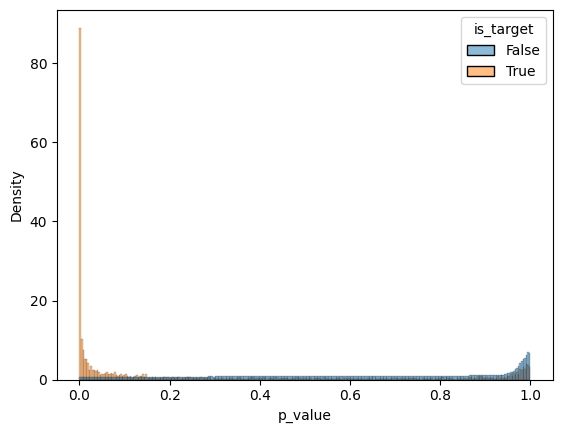

In [37]:
sns.histplot(data=combined_de_results, x='p_value', hue='is_target', stat='density', common_norm=False);
# sns.histplot(data=combined_de_results[~combined_de_results['is_target']], x='p_value');

In [38]:
combined_de_results['signif_DE'] = combined_de_results['adj_p_value'] < 0.1

In [55]:
sum(n_de_genes != 0)

1120

([], [])

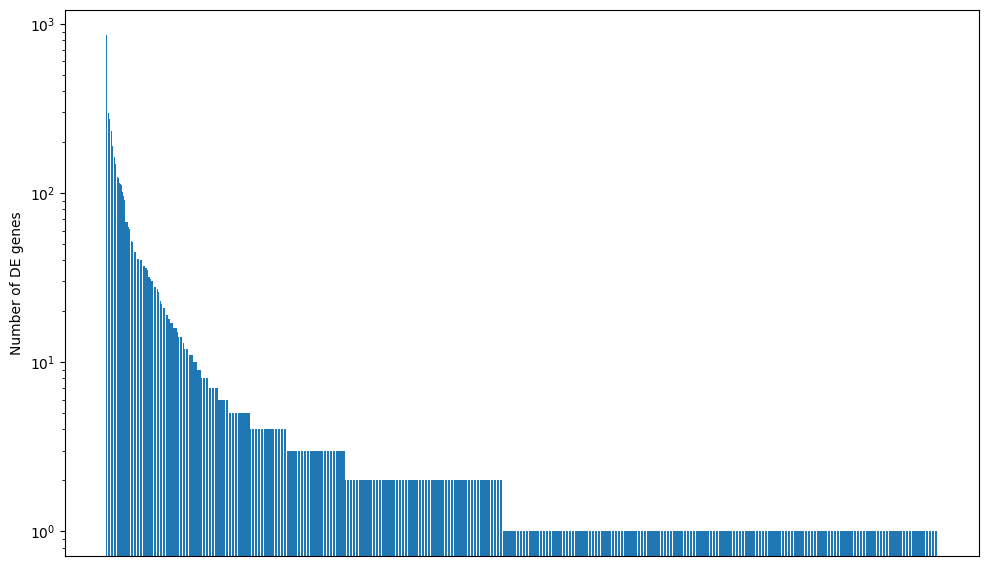

In [58]:
n_de_genes = combined_de_results.groupby('contrast')['signif_DE'].sum().sort_values(ascending=False)
n_de_genes = n_de_genes[n_de_genes > 0]

plt.figure(figsize=(10, 6))
plt.bar(range(len(n_de_genes)), n_de_genes.values)
plt.ylabel('Number of DE genes')
plt.tight_layout();
plt.yscale('log')
plt.xticks([])

## Identify effective guides

- Find guides with sufficient cells per replicate (at least 3 cells in the same replicate & condition)
- Count number of cells per guide per replicate
- Test knockdown efficiency in those guides to identify high confidence ineffective guides (in each condition)

In [8]:
guide_cell_counts = obs_df[['perturbed_gene_name', 'guide_id', 'library_id', 'culture_condition']].value_counts().reset_index()

# Mark guides with at least 3 cells per condition & sample
guide_cell_counts = guide_cell_counts[~guide_cell_counts['guide_id'].str.startswith('NTC-')]
guide_cell_counts['pass_filter'] = guide_cell_counts['count'] >= 5
guide_cell_counts.head()

# Count number of cells per guide in each condition
guides_n_cells = guide_cell_counts.groupby(['guide_id', 'culture_condition'])['count'].sum()\
    .sort_values()\
    .reset_index()\
    .pivot(index='guide_id', columns='culture_condition', values='count')\
    .fillna(0)

# Count number of replicates per guide in each condition
guides_replicates = guide_cell_counts.groupby(['guide_id', 'culture_condition'])['pass_filter'].sum()\
    .sort_values()\
    .reset_index()\
    .pivot(index='guide_id', columns='culture_condition', values='pass_filter')\
    .fillna(0)

guides_replicates['total_replicates'] = guides_replicates.sum(1) 
guides_replicates = guides_replicates.sort_values('total_replicates', ascending=False)
guides_replicates.head()

culture_condition,Rest,Stim8hr,total_replicates
guide_id,,,
SERPINE1-1,2.0,2.0,4.0
HPSE-2,2.0,2.0,4.0
CXCR5-2,2.0,2.0,4.0
HRAS-2,2.0,2.0,4.0
CXCR4-2,2.0,2.0,4.0


In [120]:
filter_guides = guides_replicates[guides_replicates['total_replicates'] == 0].index.tolist()
filter_guides_mask = ~adata.obs['guide_id'].isin(filter_guides)

adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.h5ad', backed=True)
adata.obs = obs_df.copy()
adata = adata[adata.obs['QC_mask'] & (adata.obs['guide_id'] != 'multi_sgRNA') & filter_guides_mask].to_memory()

In [148]:
from tqdm.notebook import tqdm
count_perturbed_genes = adata.obs['perturbed_gene_name'].value_counts()[1:]
test_perturbed_genes = count_perturbed_genes.index
# Split the perturbed genes into groups of 100
test_perturbed_genes_list = [test_perturbed_genes[i:i+100] for i in range(0, len(test_perturbed_genes), 100)]

all_perturbed_gene_expr_df = pd.DataFrame()

for t_genes in tqdm(test_perturbed_genes_list, desc="Processing gene groups"):
    t_genes = t_genes.to_list()
    perturbed_gene_expr_df = calculate_perturbed_gene_expression(adata[adata.obs['perturbed_gene_name'].isin(t_genes + ['NTC'])])
    perturbed_gene_expr_df['guide_id'] = adata[adata.obs['perturbed_gene_name'].isin(t_genes + ['NTC'])].obs['guide_id']
    perturbed_gene_expr_df = perturbed_gene_expr_df.drop('perturbed_gene', axis=1).dropna()
    # kd_results_c = test_knockdown_simple(perturbed_gene_expr_df, group_col='guide_id')
    all_perturbed_gene_expr_df = pd.concat([all_perturbed_gene_expr_df, perturbed_gene_expr_df])

Processing gene groups:   0%|          | 0/112 [00:00<?, ?it/s]

/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_col + '_test'] = adata.obs[perturbed_gene_col].copy()
/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_col + '_test'] = adata.obs[perturbed_gene_col].copy()
/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_col + '_test'] = adata.obs[perturbed_gene_col].copy()
/mnt/oak/users/emma/bin/GWT_perturbseq_analysis/src/1_preprocess/qc_plots.py:77: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[perturbed_gene_co

In [294]:
ntc_expr_thresh = 0.1 # min mean expression in NTCs to call bad guide
n_perturbed_cells_thresh = 10 # min number of perturbed cells to call bad guide

all_conditions = adata.obs['culture_condition'].unique()

all_kd_results = pd.DataFrame()
for cond in all_conditions:
    kd_results_stim = test_knockdown_simple(all_perturbed_gene_expr_df[all_perturbed_gene_expr_df.index.str.contains(cond)], group_col='guide_id')

    # Annotate high confidence bad guides
    kd_results_stim['low_confidence_kd_call'] = (kd_results_stim['perturbed_gene_mean_ntc'] <= ntc_expr_thresh) | \
        (kd_results_stim['n_perturbed_cells'] <= n_perturbed_cells_thresh) | \
        (kd_results_stim['t_statistic'] < -1)
    kd_results_stim['culture_condition'] = cond
    all_kd_results = pd.concat([all_kd_results, kd_results_stim])

In [321]:
# Store
all_kd_results.to_csv(datadir + 'guide_ontarget_effect_simple.csv')

In [9]:
all_kd_results = pd.read_csv(datadir + 'guide_ontarget_effect_simple.csv')

In [10]:
def plot_kd(mean_perturbed_gene_expr_df, top_n=100, figsize=(15,6), show_xlabels=True):
    # Group by guide_id instead of perturbed_gene
    guide_means = mean_perturbed_gene_expr_df.copy()

    # Select a subset of guides to plot (to avoid overcrowding)
    pl_df = guide_means.head(top_n)  # Take first 100 guides or adjust as needed
    pl_df
    plt.figure(figsize=figsize)
    # Plot mean NTC expression with error bars
    plt.errorbar(pl_df['guide_id'],
                pl_df['perturbed_gene_mean_ntc'], 
                yerr=pl_df['perturbed_gene_std_ntc'],
                fmt='o',
                color='grey',
                markersize=2,
                alpha=0.5,
                label='NT control cells')

    # Add stripplot of perturbed expression
    plt.errorbar(pl_df['guide_id'],
            pl_df['perturbed_gene_expr'],
            yerr=pl_df['perturbed_gene_expr_std'],
            fmt='o',
            markersize=2,
            color='blue',
            alpha=0.5,
            label='Perturbed cells')

    if show_xlabels:
        plt.xticks(rotation=90)
    else:
        plt.xticks([])
    plt.ylim(0)
    plt.xlabel('Guide ID')
    plt.ylabel('Perturbed gene expression (log-normalized counts)')
    plt.title('Non-significant knockdowns by guide')
    plt.legend(frameon=False)
    plt.tight_layout()

In [11]:
all_kd_results.value_counts(['signif_knockdown', 'low_confidence_kd_call'])

signif_knockdown  low_confidence_kd_call
True              True                      27477
False             True                       6521
                  False                      1366
Name: count, dtype: int64

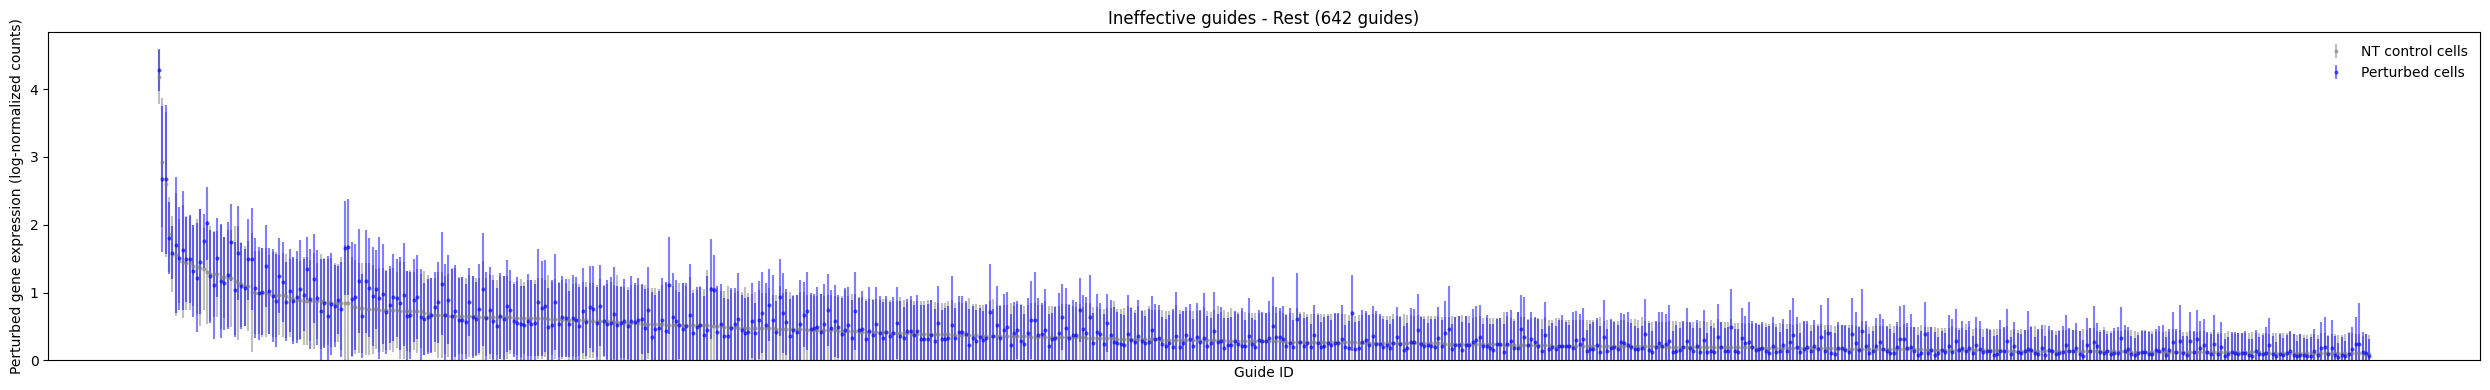

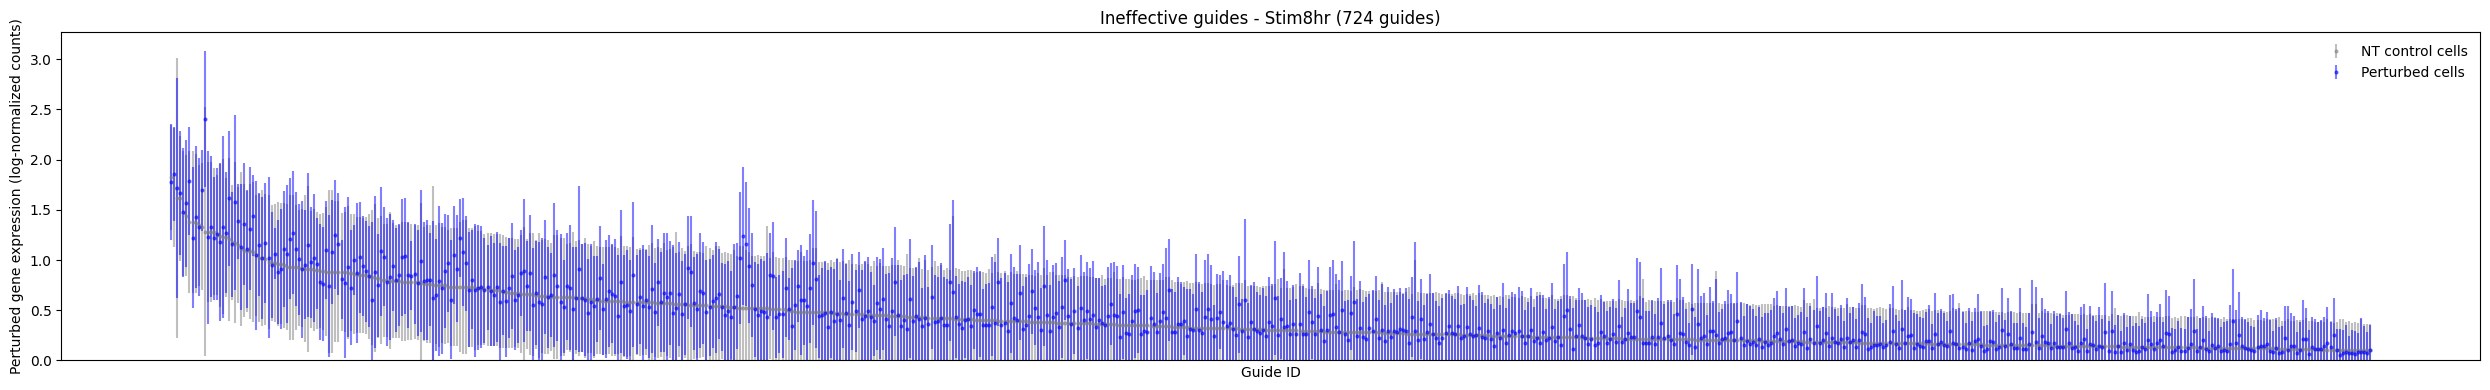

In [298]:
for cond in all_conditions:
    pl_df = all_kd_results[
        (~all_kd_results['signif_knockdown']) & 
        (~all_kd_results['low_confidence_kd_call']) & 
        (all_kd_results['culture_condition'] == cond)].sort_values('perturbed_gene_mean_ntc', ascending=False)
    plot_kd(pl_df, top_n=1100, show_xlabels=False, figsize=(25,4));
    plt.title(f'Ineffective guides - {cond} ({pl_df.shape[0]} guides)')
    plt.show()


In [12]:
# Classify if no effect in both condition and high confidence in at least one condition
all_kd_results['bad_guide'] = (~all_kd_results['signif_knockdown']) & (~all_kd_results['low_confidence_kd_call'])
n_high_confidence_bad = all_kd_results.pivot(index='guide_id', columns='culture_condition', values='bad_guide').fillna(False).sum(1)
n_signif = all_kd_results.pivot(index='guide_id', columns='culture_condition', values='signif_knockdown').fillna(False).sum(1)

no_effect_guides = n_signif.index[(n_signif == 0) & (n_high_confidence_bad >= 1)].tolist()

# Save no_effect_guides to a text file
with open(os.path.join(datadir, 'no_effect_guides.txt'), 'w') as f:
    for guide in no_effect_guides:
        f.write(f"{guide}\n")


In [1]:
len(no_effect_guides)

NameError: name 'no_effect_guides' is not defined

## Gene selection for DE analysis

In [14]:
# Don't count ineffective guides as useful replicates
guide_cell_counts_filt = guide_cell_counts[~guide_cell_counts.guide_id.isin(no_effect_guides)]

# Count number of replicates per perturbed gene in each condition
genes_replicates = guide_cell_counts_filt.groupby(['perturbed_gene_name', 'culture_condition'])['pass_filter'].sum()\
    .sort_values()\
    .reset_index()\
    .pivot(index='perturbed_gene_name', columns='culture_condition', values='pass_filter')\
    .fillna(0)

genes2test = genes_replicates >= 3
# Create a dictionary where keys are column names and values are lists of indices where the value is True
genes2test_dict = {col: genes2test.index[genes2test[col]].tolist() for col in genes2test.columns}
len(genes2test_dict['Stim8hr'])

4549

## Load pseudobulked data and filter

In [119]:
pbulk_adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.DE_pseudobulk.h5ad', backed=True)

In [120]:
if not 'keep_for_DE' in pbulk_adata.obs:
    # Add name of perturbed gene
    guide_to_gene_id = dict(zip(obs_df['guide_id'], obs_df['perturbed_gene_name']))
    pbulk_adata.obs['perturbed_gene_name'] = pbulk_adata.obs['sgrna'].map(guide_to_gene_id)

    # Exclude guides with no detectable knockdown
    good_sgrna_mask = ~pbulk_adata.obs['sgrna'].isin(no_effect_guides)

    # Test perturbed genes passing filters in all conditions
    test_genes = np.intersect1d(*[x for x in genes2test_dict.values()]).tolist()
    test_genes.append('NTC')
    passing_genes_mask = pbulk_adata.obs['perturbed_gene_name'].isin(test_genes)

    multi_guide_mask = pbulk_adata.obs['sgrna'] != 'multi_sgRNA'
    pbulk_adata.obs['keep_for_DE'] = good_sgrna_mask & multi_guide_mask & passing_genes_mask
    pbulk_adata.write_h5ad()

    pbulk_adata = pbulk_adata[pbulk_adata.obs['keep_for_DE']].to_memory()
else:
    pbulk_adata = pbulk_adata[pbulk_adata.obs['keep_for_DE']].to_memory()

## Feature selection for DE

In [121]:

feature_selection_var = feature_selection(
    pbulk_adata,
    n_hvgs = 10000,
    subset_adata=False,
    highx_min_mean_counts = 2000,
    highx_min_pct_dropouts_by_counts = 0.5,
    lowx_max_pct_dropouts_by_counts = 99.9,
    return_all=True
    )
feature_selection_var = feature_selection_var.drop('CUSTOM001_PuroR')

all_targets = pbulk_adata.obs['target'].unique()
feature_selection_var['is_target'] = feature_selection_var.index.isin(all_targets)

DE_test_genes = feature_selection_var[feature_selection_var['highly_variable'] | feature_selection_var['is_target']].index.tolist()
# Save DE_test_genes to a text file
with open(f'{datadir}/DE_test_genes.txt', 'w') as f:
    for gene in DE_test_genes:
        f.write(f"{gene}\n")

## Split perturbations into chunks

In [134]:

all_targets = pbulk_adata.obs['target'].unique().tolist()
all_targets.remove('NTC')
chunk_size = 50

# Randomize targets before splitting (without replacement)
np.random.seed(1423)
np.random.shuffle(all_targets)

# Split all_targets into groups of 100
target_chunks = [all_targets[i:i+chunk_size] for i in range(0, len(all_targets), chunk_size)]

# Initialize a binary matrix with zeros
target_chunk_matrix = pd.DataFrame(0, 
                                  index=all_targets, 
                                  columns=[f'chunk_{i}' for i in range(len(target_chunks))])

# Fill the matrix with 1s for each target in its respective chunk
for chunk_idx, chunk in enumerate(target_chunks):
    target_chunk_matrix.loc[chunk, f'chunk_{chunk_idx}'] = 1

target_chunk_matrix.to_csv(f'{datadir}/DE_target2chunk.csv.gz', compression='gzip')

In [135]:
target_chunk_matrix

,chunk_0,chunk_1,chunk_2,chunk_3,chunk_4,chunk_5,chunk_6,chunk_7,chunk_8,chunk_9,...,chunk_55,chunk_56,chunk_57,chunk_58,chunk_59,chunk_60,chunk_61,chunk_62,chunk_63,chunk_64
ENSG00000085265,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000130066,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000136404,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000075539,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000263956,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000107643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ENSG00000114988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ENSG00000196646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ENSG00000156574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Test DE workflow

In [136]:
ms_perturb_data = MultistatePerturbSeqDataset(pbulk_adata)

In [137]:
test_genes = target_chunk_matrix['chunk_0'].index.tolist()

In [138]:
test_genes

['ENSG00000085265',
 'ENSG00000130066',
 'ENSG00000136404',
 'ENSG00000075539',
 'ENSG00000263956',
 'ENSG00000273079',
 'ENSG00000128607',
 'ENSG00000123575',
 'ENSG00000122873',
 'ENSG00000115297',
 'ENSG00000121940',
 'ENSG00000080561',
 'ENSG00000172780',
 'ENSG00000185875',
 'ENSG00000095383',
 'ENSG00000167380',
 'ENSG00000137145',
 'ENSG00000064961',
 'ENSG00000130669',
 'ENSG00000169083',
 'ENSG00000197694',
 'ENSG00000100100',
 'ENSG00000143127',
 'ENSG00000059377',
 'ENSG00000116704',
 'ENSG00000112245',
 'ENSG00000164463',
 'ENSG00000165689',
 'ENSG00000184860',
 'ENSG00000162630',
 'ENSG00000177570',
 'ENSG00000249437',
 'ENSG00000198208',
 'ENSG00000114439',
 'ENSG00000162851',
 'ENSG00000156535',
 'ENSG00000184786',
 'ENSG00000175707',
 'ENSG00000134070',
 'ENSG00000081189',
 'ENSG00000164484',
 'ENSG00000170100',
 'ENSG00000127415',
 'ENSG00000107833',
 'ENSG00000197647',
 'ENSG00000047579',
 'ENSG00000102178',
 'ENSG00000102893',
 'ENSG00000173467',
 'ENSG00000003756',


In [ ]:
results = ms_perturb_data.run_target_DE(test_state=['Stim8hr'], test_targets=test_genes)

In [99]:
results['log10_adj_p_value'] = -np.log10(results['adj_p_value'])

In [102]:
results

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast,culture_condition,log10_adj_p_value
0,ENSG00000136021,4.196187,1.186171,0.307115,3.862298,0.000112,0.601497,ENSG00000183283,Stim8hr,0.220767
1,ENSG00000171606,1.374872,1.750634,0.456201,3.837423,0.000124,0.601497,ENSG00000183283,Stim8hr,0.220767
2,ENSG00000095059,5.293415,1.053441,0.277292,3.799026,0.000145,0.601497,ENSG00000183283,Stim8hr,0.220767
3,ENSG00000175595,2.342736,1.425610,0.386888,3.684816,0.000229,0.710751,ENSG00000183283,Stim8hr,0.148283
4,ENSG00000154144,2.435679,1.329450,0.379474,3.503401,0.000459,0.998067,ENSG00000183283,Stim8hr,0.000840
...,...,...,...,...,...,...,...,...,...,...
124215,ENSG00000203666,0.193473,-0.000903,1.538693,-0.000587,0.999532,0.999717,ENSG00000130775,Stim8hr,0.000123
124216,ENSG00000050426,2.717316,0.000281,0.494510,0.000568,0.999547,0.999717,ENSG00000130775,Stim8hr,0.000123
124217,ENSG00000186532,3.032855,-0.000264,0.474489,-0.000556,0.999556,0.999717,ENSG00000130775,Stim8hr,0.000123
124218,ENSG00000025423,0.405503,-0.000498,1.140889,-0.000437,0.999651,0.999732,ENSG00000130775,Stim8hr,0.000116


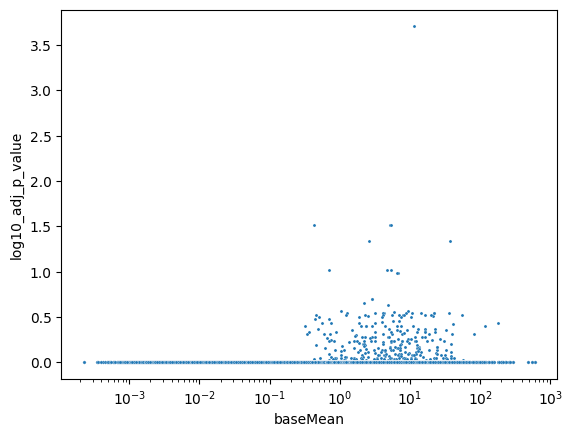

In [109]:
sns.scatterplot(data=results, x='baseMean', y='log10_adj_p_value', s=5);
plt.xscale('log')

In [368]:
pbulk_adata

AnnData object with n_obs × n_vars = 62217 × 18130
    obs: 'sample_id', 'donor_id', 'culture_condition', 'sgrna', 'target', 'perturbed_gene_name'
    var: 'gene_ids', 'gene_name', 'mt'
    uns: 'MultistatePerturbSeqDataset'
    layers: 'count_nonzero'

In [10]:
np.random.seed(13421)
sample_perturbations = np.random.choice(passing_genes_both, size=100, replace=False).tolist()
if 'NTC' not in sample_perturbations:
    sample_perturbations.append('NTC')

In [24]:

adata_smol = adata[adata.obs['perturbed_gene_name'].isin(sample_perturbations)].to_memory()
sc.pp.highly_variable_genes(adata_smol, flavor='seurat_v3', n_top_genes=10000, subset=False)

keep_genes = ((adata_smol.var['highly_variable']) | adata_smol.var['gene_ids'].isin(adata_smol.obs['perturbed_gene_id']) )
print(sum(keep_genes))
adata_smol = adata_smol[:, keep_genes]

adata_smol.obs['perturbed_gene_id'] = np.where(adata_smol.obs['perturbed_gene_name'] == 'NTC', 'NTC', adata_smol.obs['perturbed_gene_id'] )
# adata_smol.write_h5ad('/mnt/oak/users/emma/data/GWT/test_datasets/test_subset_CRiCD4IL2_Illumina_merged.gex.counts.postQC.h5ad')

10041


/tmp/ipykernel_368465/2545644107.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smol.obs['perturbed_gene_id'] = np.where(adata_smol.obs['perturbed_gene_name'] == 'NTC', 'NTC', adata_smol.obs['perturbed_gene_id'] )


In [6]:
# adata_smol = sc.read_h5ad('/mnt/oak/users/emma/data/GWT/test_datasets/test_subset_CRiCD4IL2_Illumina_merged.gex.counts.postQC.h5ad')

In [27]:
adata_smol

AnnData object with n_obs × n_vars = 19881 × 10038
    obs: 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'Unnamed: 0', 'experiment_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'library_prep_kit', 'probe_hyb_loading', 'GEM_loading', 'sequencing_platform', 'guide_id', 'top_guide_umi_counts', 'sequence', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type', 'low_quality', 'louvain'
    var: 'gene_ids', 'gene_name', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_sample_id_colors', 'culture_condition_colors', 'donor_id_colors', 'hvg', 'log1p', 'louvain', 'louvain_colors', 'low_quality_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
   

In [28]:
condition_col = 'culture_condition'
sgrna_col = 'guide_id'

mspert_data = MultistatePerturbSeqDataset(
    adata_smol,
    state_col=condition_col,
    sample_cols = ['donor_id', condition_col],
    target_col='perturbed_gene_id',
    perturbation_type = 'CRISPRi',
    sgrna_col = sgrna_col,
    control_level='NTC'
)
mspert_data.pseudobulk()

## Test glmGamPoi vs PyDESeq2

In [12]:
pbulk_sdata_X = mspert_data.adata.X.toarray()
pbulk_sdata_obs = mspert_data.adata.obs.copy()
pbulk_sdata_var = mspert_data.adata.var.copy()

In [13]:
pbulk_sdata_X.shape

(2469, 5070)

In [14]:
%%R -i pbulk_sdata_X -i pbulk_sdata_obs -i pbulk_sdata_var
head(pbulk_sdata_obs)

                                        sample_id  donor_id culture_condition
CE0008162_Rest_ABCB6-1     CE0008162_Rest_ABCB6-1 CE0008162              Rest
CE0008162_Rest_ABCB6-2     CE0008162_Rest_ABCB6-2 CE0008162              Rest
CE0008162_Rest_ALG10B-2   CE0008162_Rest_ALG10B-2 CE0008162              Rest
CE0008162_Rest_ALOX5AP-1 CE0008162_Rest_ALOX5AP-1 CE0008162              Rest
CE0008162_Rest_ALOX5AP-2 CE0008162_Rest_ALOX5AP-2 CE0008162              Rest
CE0008162_Rest_ANGPT2-1   CE0008162_Rest_ANGPT2-1 CE0008162              Rest
                             sgrna          target
CE0008162_Rest_ABCB6-1     ABCB6-1 ENSG00000115657
CE0008162_Rest_ABCB6-2     ABCB6-2 ENSG00000115657
CE0008162_Rest_ALG10B-2   ALG10B-2 ENSG00000175548
CE0008162_Rest_ALOX5AP-1 ALOX5AP-1 ENSG00000132965
CE0008162_Rest_ALOX5AP-2 ALOX5AP-2 ENSG00000132965
CE0008162_Rest_ANGPT2-1   ANGPT2-1 ENSG00000091879


In [15]:
%%R
sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)

## Fit
model_confounders <- glm_gp(sce, design = ~ donor_id + culture_condition)

confounder_effects <- predict(model_confounders, type='response')
log_confounder_effects <- log(confounder_effects)

# Use this as offset in the second model 
model_ko <- glm_gp(
    sce, 
    design = ~ target:culture_condition - 1,
    offset = log_confounder_effects
    )

In [16]:
%%R -o de_res_c
t <- "ENSG00000115657"
de_res_c <- test_de(
    model_ko, 
    contrast = cond(target = t, culture_condition = "Rest") - cond(target = "NTC", culture_condition = "Rest"),
    compute_lfc_se = TRUE
    )

de_res_c[,'gene_name'] <- pbulk_sdata_var['gene_name']

In [69]:
# %%R
# test_outs <- predict(model_ko,  se.fit=TRUE, type='link',
#                       offset=0, #for asserting equality with lfc
#                       )

Exception ignored from cffi callback <function _processevents at 0x7fe523c482c0>:
Traceback (most recent call last):
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


In [17]:
de_res_c

,name,pval,adj_pval,f_statistic,df1,df2,lfc,lfc_se,gene_name
1,row_001,0.487884,1.0,4.813454e-01,1,2291.85044,0.527019,0.775207,C1orf112
2,row_002,0.608056,1.0,2.630887e-01,1,2291.85044,-10.000000,NaN,CFH
3,row_003,1.000000,1.0,0.000000e+00,1,2291.85044,0.000000,NaN,CFTR
4,row_004,0.289131,1.0,1.124184e+00,1,2291.85044,0.854606,0.781600,CYP51A1
5,row_005,0.965575,1.0,1.863073e-03,1,2291.85044,-10.000000,NaN,HS3ST1
...,...,...,...,...,...,...,...,...,...
5066,row_5066,1.000000,1.0,0.000000e+00,1,2291.85044,0.000000,NaN,ENSG00000284797
5067,row_5067,1.000000,1.0,0.000000e+00,1,2291.85044,0.000000,NaN,CCDC39
5068,row_5068,0.475933,1.0,5.083359e-01,1,2291.85044,0.588313,NaN,ARHGAP11B
5069,row_5069,1.000000,1.0,0.000000e+00,1,2291.85044,0.000000,NaN,ENSG00000290798


In [29]:
# design_formula = f"~{' + '.join(covariates)} + {dds.cell_state_obs} + {dds.cell_state_obs}*{temp_col}"
model = pertpy.tl.PyDESeq2(mspert_data.adata, design='~ donor_id + culture_condition + target*culture_condition')
model.fit(quiet=True)

Fitting dispersions...
... done in 0.20 seconds.

Fitting MAP dispersions...
... done in 0.27 seconds.

Fitting LFCs...
... done in 0.29 seconds.



In [ ]:
model = pertpy.tl.PyDESeq2(mspert_data.adata, design='~ donor_id + culture_condition + target*culture_condition')
model.fit(quiet=True)
t = "ENSG00000115657"
t_contrast = (model.cond(target = t, culture_condition = "Rest") - model.cond(target = "NTC", culture_condition = "Rest")) 
res_df = model.test_contrasts(t_contrast)


Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  padj
TSPAN6           0.000636        0.033845

... done in 2.38 seconds.



In [20]:
res_df = res_df.set_index('variable').loc[de_res_c['gene_name']]

In [21]:
de_res_c = de_res_c.set_index('gene_name')

In [22]:
merged_df = pd.concat([res_df, de_res_c], axis=1).sort_values('lfc')
merged_df[merged_df['lfc_se'].isna()].sort_values('adj_pval')

,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast,name,pval,adj_pval,f_statistic,df1,df2,lfc,lfc_se
ABHD11,0.594755,2.942599,0.616454,4.773429,0.000002,0.009012,None,row_948,0.000008,0.038225,20.143647,1,2291.85044,3.882305,NaN
BRCA1,1.971886,1.741991,0.500239,3.482318,0.000497,0.578394,None,row_082,0.000372,0.472126,12.703231,1,2291.85044,2.381829,NaN
ADAT2,3.116404,1.845804,0.506723,3.642630,0.000270,0.578394,None,row_4512,0.000298,0.472126,13.120524,1,2291.85044,2.815912,NaN
SLC43A3,6.549506,1.604720,0.491840,3.262685,0.001104,0.783750,None,row_2049,0.000279,0.472126,13.248793,1,2291.85044,2.636931,NaN
CDC6,3.474465,1.768228,0.585628,3.019370,0.002533,0.999954,None,row_610,0.000611,0.541058,11.773374,1,2291.85044,2.535967,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZMYM1,0.678199,-2.074985,1.922064,-1.079561,0.280338,0.999954,None,row_4582,0.081527,1.000000,3.036860,1,2291.85044,-10.000000,NaN
UBXN10,0.078365,0.019010,4.685564,0.004057,0.996763,0.999954,None,row_3150,0.730786,1.000000,0.118420,1,2291.85044,-10.000000,NaN
DTHD1,0.011511,0.148685,41.441035,0.003588,0.997137,0.999954,None,row_4583,0.943762,1.000000,0.004977,1,2291.85044,-10.000000,NaN
BEND4,0.002057,0.153261,41.440938,0.003698,0.997049,0.999954,None,row_4503,0.966035,1.000000,0.001814,1,2291.85044,-10.000000,NaN


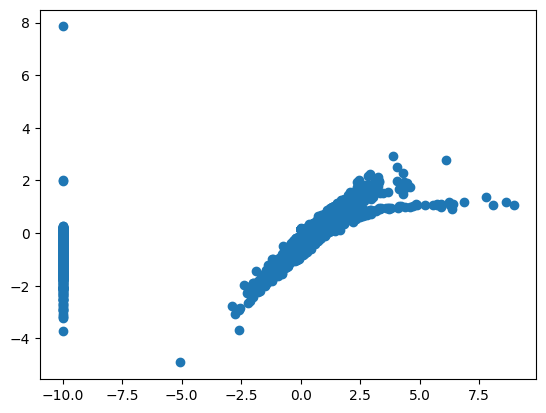

In [25]:
plt.scatter(de_res_c['lfc'], res_df['log_fc'])

Final results: test on 2469 samples & 203 coefficients
- 2000 hvgs: 1.20 mins glmGamPoi / 58 sec PyDESeq2
- 5000 hvgs: 3.48+1.47 mins glmGamPoi / 1.52 + 0.1 min PyDESeq2
- 10000 hvgs:  ?  / 4.41 + 0.2 mins PyDESeq2

## Test divide & conquer

Use less genes for this test

In [152]:
np.random.seed(13421)
sample_perturbations = np.random.choice(passing_genes_both, size=100, replace=False).tolist()
if 'NTC' not in sample_perturbations:
    sample_perturbations.append('NTC')

adata_smol = adata[adata.obs['perturbed_gene_name'].isin(sample_perturbations)].to_memory()
sc.pp.highly_variable_genes(adata_smol, flavor='seurat_v3', n_top_genes=5000, subset=False)

keep_genes = ((adata_smol.var['highly_variable']) | adata_smol.var['gene_ids'].isin(adata_smol.obs['perturbed_gene_id']) )
print(sum(keep_genes))
adata_smol = adata_smol[:, keep_genes]

adata_smol.obs['perturbed_gene_id'] = np.where(adata_smol.obs['perturbed_gene_name'] == 'NTC', 'NTC', adata_smol.obs['perturbed_gene_id'] )

condition_col = 'culture_condition'
sgrna_col = 'guide_id'

mspert_data = MultistatePerturbSeqDataset(
    adata_smol,
    state_col=condition_col,
    sample_cols = ['donor_id', condition_col],
    target_col='perturbed_gene_id',
    perturbation_type = 'CRISPRi',
    sgrna_col = sgrna_col,
    control_level='NTC'
)
mspert_data.pseudobulk()

5070


/tmp/ipykernel_3503301/198724291.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smol.obs['perturbed_gene_id'] = np.where(adata_smol.obs['perturbed_gene_name'] == 'NTC', 'NTC', adata_smol.obs['perturbed_gene_id'] )


In [153]:
test_targets = mspert_data.design_matrix['target'].unique()
test_targets = test_targets[test_targets != 'NTC']

# Split targets into 2 groups, creating 3 different splits
import numpy as np

# Create a list to store all splits
splits = []

# Create splits 
seeds = [None, 42, 123]  
for i, seed in enumerate(seeds):
    if seed is None:
        # Sequential split
        group1 = test_targets[:len(test_targets)//2]
        group2 = test_targets[len(test_targets)//2:]
    else:
        # Random split with seed
        np.random.seed(seed)
        shuffled_targets = np.random.permutation(test_targets)
        group1 = shuffled_targets[:len(shuffled_targets)//2]
        group2 = shuffled_targets[len(shuffled_targets)//2:]
    
    # Add NTC to both groups
    group1 = np.append(group1, 'NTC')
    group2 = np.append(group2, 'NTC')
    
    splits.append((group1, group2))


In [131]:
np.random.seed(321)
de_test_targets = np.random.choice(test_targets, size=10, replace=False)

# Dictionary to store models for each split
models = {}

# Fit a model for each group in splits
for i, (group1, group2) in enumerate(splits):
    print(i)
    # Fit model for group1
    pbulk_adata_group1 = mspert_data.adata[mspert_data.adata.obs['target'].isin(group1)].copy()
    model_group1 = pertpy.tl.PyDESeq2(pbulk_adata_group1, design='~ donor_id + culture_condition + target*culture_condition')
    model_group1.fit(quiet=True)
    models[f'split{i}_group1'] = model_group1
    
    # Fit model for group2
    pbulk_adata_group2 = mspert_data.adata[mspert_data.adata.obs['target'].isin(group2)].copy()
    model_group2 = pertpy.tl.PyDESeq2(pbulk_adata_group2, design='~ donor_id + culture_condition + target*culture_condition')
    model_group2.fit(quiet=True)
    models[f'split{i}_group2'] = model_group2




0


Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Fitting dispersions...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 0.87 seconds.

Fitting LFCs...
... done in 0.06 seconds.



1


Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.04 seconds.



2


Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.87 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Fitting dispersions...


LinAlgError: Singular matrix

In [136]:

# Dictionary to store results for each model and target
results = {}

# For each model, test each target
for model_name, model in models.items():
    results[model_name] = {}
    model_res_df = pd.DataFrame()
    for t in de_test_targets:
        # Check if target is in the model's design matrix
        if f'target[T.{t}]:culture_condition[T.Stim8hr]' in model.design.columns:
            # Create contrast for target vs NTC in Rest condition
            t_contrast = (model.cond(target=t, culture_condition="Rest") - 
                          model.cond(target="NTC", culture_condition="Rest"))
            # Run the test and store results
            res_df = model.test_contrasts(t_contrast)
            res_df['contrast'] = t
            model_res_df = pd.concat([model_res_df, res_df])
    
    results[model_name] = model_res_df


Running Wald tests...
... done in 7.38 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.088287       -0.407408   0.767974 -0.530497  0.595767   
CFH              0.082714        0.168759   4.399936  0.038355  0.969405   
CFTR             0.003412        0.558963  37.073279  0.015077  0.987971   
CYP51A1          4.648801        0.080037   0.675124  0.118552  0.905630   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.187059       -0.297384   0.840447 -0.353840  0.723459   
LINC02929        0.000222        0.554450  37.073397  0.014955  0.988068   
ENSG00000285938  0.007683        0.555628  37

Running Wald tests...
... done in 0.80 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.088287        0.176238   0.605254  0.291180  0.770914   
CFH              0.082714       -0.165767   4.449565 -0.037255  0.970282   
CFTR             0.003412        0.222227  37.082436  0.005993  0.995218   
CYP51A1          4.648801        0.024048   0.605300  0.039729  0.968309   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.187059       -1.048013   0.863575 -1.213574  0.224910   
LINC02929        0.000222        0.205205  37.082569  0.005534  0.995585   
ENSG00000285938  0.007683        0.209365  37

... done in 0.81 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.088287       -1.315766   0.780921 -1.684890  0.092010   
CFH              0.082714        0.519498   4.265242  0.121798  0.903059   
CFTR             0.003412        0.067243  37.097172  0.001813  0.998554   
CYP51A1          4.648801       -0.153944   0.609115 -0.252734  0.800474   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.187059       -1.647316   0.959717 -1.716460  0.086078   
LINC02929        0.000222        0.075847  37.097620  0.002045  0.998369   
ENSG00000285938  0.007683        0.074205  37

... done in 0.83 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098       -0.653537  37.094401 -0.017618  0.985943   
C1orf112         3.087545        0.009664   0.527959  0.018304  0.985397   
CFH              0.075635       -0.104586   4.522760 -0.023124  0.981551   
CFTR             0.004253       -0.664797  37.094491 -0.017922  0.985701   
CYP51A1          4.659760       -0.026844   0.528996 -0.050745  0.959529   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.176742       -1.652955   0.836662 -1.975655  0.048194   
LINC02929        0.000222       -0.653556  37.094402 -0.017619  0.985943   
ENSG00000285938  0.007219       -0.655560  37

... done in 0.83 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098       -0.097275  37.100679 -0.002622  0.997908   
C1orf112         3.087545        0.861775   0.505574  1.704549  0.088279   
CFH              0.075635       -0.509903   4.748733 -0.107377  0.914490   
CFTR             0.004253       -0.108546  37.100369 -0.002926  0.997666   
CYP51A1          4.659760       -0.137795   0.605978 -0.227392  0.820119   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.176742        0.222520   0.626661  0.355087  0.722524   
LINC02929        0.000222       -0.097293  37.100678 -0.002622  0.997908   
ENSG00000285938  0.007219       -0.099299  37

... done in 0.86 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098        0.074076  32.153004  0.002304  0.998162   
C1orf112         3.087545        0.536387   0.470963  1.138917  0.254738   
CFH              0.075635       -0.347698   4.114686 -0.084502  0.932657   
CFTR             0.004253        0.062377  32.153084  0.001940  0.998452   
CYP51A1          4.659760        0.668911   0.434092  1.540943  0.123331   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.176742       -0.004998   0.578352 -0.008641  0.993105   
LINC02929        0.000222        0.074058  32.153004  0.002303  0.998162   
ENSG00000285938  0.007219        0.071590  32

Running Wald tests...
... done in 1.01 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098       -0.753612  37.105048 -0.020310  0.983796   
C1orf112         3.087545        0.421009   0.492469  0.854894  0.392610   
CFH              0.075635       -1.166560   4.766232 -0.244755  0.806646   
CFTR             0.004253       -0.765300  37.104716 -0.020625  0.983544   
CYP51A1          4.659760       -0.098547   0.511768 -0.192561  0.847303   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.176742       -0.557422   0.638924 -0.872440  0.382969   
LINC02929        0.000222       -0.754054  37.105065 -0.020322  0.983786   
ENSG00000285938  0.007219       -0.756058  37

Running Wald tests...
... done in 1.43 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098        0.468966  37.107423  0.012638  0.989917   
C1orf112         3.087545       -0.363274   0.708435 -0.512784  0.608102   
CFH              0.075635        0.083937   4.794112  0.017508  0.986031   
CFTR             0.004253        0.474851  37.107782  0.012797  0.989790   
CYP51A1          4.659760       -0.229217   0.682741 -0.335730  0.737074   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.176742       -1.118397   0.956829 -1.168857  0.242461   
LINC02929        0.000222        0.468977  37.107424  0.012638  0.989916   
ENSG00000285938  0.007219        0.470039  37

... done in 0.80 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098       -0.579780  37.110567 -0.015623  0.987535   
C1orf112         3.087545       -0.246197   0.556273 -0.442584  0.658067   
CFH              0.075635        0.406972   4.504957  0.090339  0.928018   
CFTR             0.004253       -0.590574  37.110207 -0.015914  0.987303   
CYP51A1          4.659760        1.164437   0.419866  2.773353  0.005548   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.176742       -0.583244   0.660310 -0.883288  0.377081   
LINC02929        0.000222       -0.579798  37.110566 -0.015624  0.987535   
ENSG00000285938  0.007219       -0.581803  37

... done in 0.82 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098        0.550668  37.045428  0.014865  0.988140   
C1orf112         3.053736       -0.420548   0.769250 -0.546699  0.584586   
CFH              0.077580        0.165673   4.667724  0.035493  0.971686   
CFTR             0.003840        0.555686  37.045292  0.015000  0.988032   
CYP51A1          4.624748        0.073898   0.673482  0.109725  0.912628   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.150554       -0.299326   0.841703 -0.355620  0.722125   
LINC02929        0.000222        0.550680  37.045427  0.014865  0.988140   
ENSG00000285938  0.007199        0.551747  37

Running Wald tests...
... done in 0.83 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098       -0.753513  37.058413 -0.020333  0.983778   
C1orf112         3.053736        0.419320   0.490438  0.854991  0.392556   
CFH              0.077580       -1.164827   4.707128 -0.247460  0.804552   
CFTR             0.003840       -0.763488  37.058131 -0.020602  0.983563   
CYP51A1          4.624748       -0.097876   0.511719 -0.191269  0.848315   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.150554       -0.558584   0.640062 -0.872703  0.382825   
LINC02929        0.000222       -0.753953  37.058431 -0.020345  0.983768   
ENSG00000285938  0.007199       -0.755965  37

... done in 0.83 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098        0.200153  37.054601  0.005402  0.995690   
C1orf112         3.053736        0.178265   0.605094  0.294607  0.768294   
CFH              0.077580       -0.166003   4.717518 -0.035189  0.971929   
CFTR             0.003840        0.219511  37.054435  0.005924  0.995273   
CYP51A1          4.624748        0.029219   0.602551  0.048493  0.961324   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.150554       -1.043295   0.865116 -1.205960  0.227833   
LINC02929        0.000222        0.200194  37.054601  0.005403  0.995689   
ENSG00000285938  0.007199        0.203780  37

... done in 0.84 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098        0.471279  37.060769  0.012716  0.989854   
C1orf112         3.053736       -0.360597   0.706646 -0.510294  0.609846   
CFH              0.077580        0.085541   4.734293  0.018068  0.985584   
CFTR             0.003840        0.476292  37.061072  0.012852  0.989746   
CYP51A1          4.624748       -0.228119   0.682768 -0.334110  0.738297   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.150554       -1.116833   0.957671 -1.166198  0.243535   
LINC02929        0.000222        0.471290  37.060770  0.012717  0.989854   
ENSG00000285938  0.007199        0.472356  37

... done in 0.82 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.122277        0.003341   0.527610  0.006333  0.994947   
CFH              0.080774       -0.101437   4.228511 -0.023989  0.980862   
CFTR             0.003826       -0.662465  37.122437 -0.017845  0.985762   
CYP51A1          4.684159       -0.029252   0.530994 -0.055089  0.956067   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.213390       -1.654379   0.835438 -1.980254  0.047675   
LINC02929        0.000223       -0.652155  37.122356 -0.017568  0.985984   
ENSG00000285938  0.007705       -0.654411  37

... done in 0.81 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.122277        0.861553   0.504892  1.706412  0.087931   
CFH              0.080774       -0.504462   4.467136 -0.112927  0.910088   
CFTR             0.003826       -0.103921  37.128312 -0.002799  0.997767   
CYP51A1          4.684159       -0.134089   0.607671 -0.220661  0.825357   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.213390        0.225005   0.624521  0.360285  0.718634   
LINC02929        0.000223       -0.093600  37.128593 -0.002521  0.997989   
ENSG00000285938  0.007705       -0.095859  37

... done in 0.83 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.122277        0.539932   0.470104  1.148537  0.250747   
CFH              0.080774       -0.348470   3.870830 -0.090025  0.928268   
CFTR             0.003826        0.062381  32.177344  0.001939  0.998453   
CYP51A1          4.684159        0.670099   0.436159  1.536364  0.124449   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.213390       -0.004879   0.576350 -0.008465  0.993246   
LINC02929        0.000223        0.073132  32.177272  0.002273  0.998187   
ENSG00000285938  0.007705        0.070413  32

Running Wald tests...
... done in 0.83 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.122277       -1.318213   0.782563 -1.684481  0.092089   
CFH              0.080774        0.516003   4.312777  0.119645  0.904764   
CFTR             0.003826        0.064009  37.143664  0.001723  0.998625   
CYP51A1          4.684159       -0.155775   0.608987 -0.255794  0.798110   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.213390       -1.648997   0.958832 -1.719797  0.085469   
LINC02929        0.000223        0.074330  37.144197  0.002001  0.998403   
ENSG00000285938  0.007705        0.072691  37

Running Wald tests...
... done in 0.84 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.122277       -0.250665   0.555894 -0.450923  0.652045   
CFH              0.080774        0.421343   4.207100  0.100150  0.920225   
CFTR             0.003826       -0.587031  37.138288 -0.015807  0.987389   
CYP51A1          4.684159        1.164814   0.422553  2.756608  0.005840   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.213390       -0.578153   0.657539 -0.879268  0.379256   
LINC02929        0.000223       -0.577188  37.138623 -0.015541  0.987600   
ENSG00000285938  0.007705       -0.579445  37

... done in 0.95 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  padj
TSPAN6           0.000000             NaN        NaN       NaN       NaN   NaN
C1orf112         3.099589        0.178103   0.607063  0.293384  0.769228   1.0
CFH              0.078476       -0.161117   4.578296 -0.035192  0.971927   1.0
CFTR             0.004006        0.227638  37.073035  0.006140  0.995101   1.0
CYP51A1          4.654560        0.025489   0.606036  0.042059  0.966452   1.0
...                   ...             ...        ...       ...       ...   ...
ARHGAP11B        2.186436       -1.046879   0.864067 -1.211572  0.225676   1.0
LINC02929        0.000222        0.206716  37.073217  0.005576  0.995551   1.0
ENSG00000285938  0

... done in 1.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.099589       -1.314858   0.782923 -1.679421  0.093070   
CFH              0.078476        0.517662   4.399279  0.117670  0.906329   
CFTR             0.004006        0.064924  37.087704  0.001751  0.998603   
CYP51A1          4.654560       -0.153862   0.610242 -0.252132  0.800939   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.186436       -1.646694   0.960265 -1.714834  0.086376   
LINC02929        0.000222        0.075196  37.088237  0.002027  0.998382   
ENSG00000285938  0.008701        0.073627  37

... done in 1.05 seconds.



In [137]:
# Create a dictionary to store concatenated results for each target
target_results = {}

for t in de_test_targets:
    # Initialize an empty DataFrame to store all results for this target
    all_results_for_target = pd.DataFrame()
    
    for i in range(3):  # Assuming 3 splits based on previous code
        for group in ['group1', 'group2']:
            model_key = f'split{i}_{group}'
            if model_key in results and not results[model_key].empty:
                # Filter results for this target
                target_df = results[model_key][results[model_key].contrast == t]
                if not target_df.empty:
                    # Add columns for split and group
                    target_df = target_df.copy()
                    target_df['split'] = i
                    target_df['group'] = group
                    # Concatenate to the results for this target
                    all_results_for_target = pd.concat([all_results_for_target, target_df])
    
    # Store the concatenated results for this target
    target_results[t] = all_results_for_target
    
    # Print summary
    if not all_results_for_target.empty:
        print(f"Target {t}: Found in {len(all_results_for_target)} model(s)")
    else:
        print(f"Target {t}: No results found")

Target ENSG00000105939: Found in 10068 model(s)
Target ENSG00000124784: Found in 10068 model(s)
Target ENSG00000173253: Found in 10068 model(s)
Target ENSG00000137642: Found in 10068 model(s)
Target ENSG00000124164: Found in 10068 model(s)
Target ENSG00000105327: Found in 15102 model(s)
Target ENSG00000278570: Found in 10068 model(s)
Target ENSG00000140463: Found in 15102 model(s)
Target ENSG00000006377: No results found
Target ENSG00000159596: Found in 15102 model(s)


In [ ]:
target_results

dict_keys(['ENSG00000105939', 'ENSG00000124784', 'ENSG00000173253', 'ENSG00000137642', 'ENSG00000124164', 'ENSG00000105327', 'ENSG00000278570', 'ENSG00000140463', 'ENSG00000006377', 'ENSG00000159596'])

In [145]:
target_results.keys()

dict_keys(['ENSG00000105939', 'ENSG00000124784', 'ENSG00000173253', 'ENSG00000137642', 'ENSG00000124164', 'ENSG00000105327', 'ENSG00000278570', 'ENSG00000140463', 'ENSG00000006377', 'ENSG00000159596'])

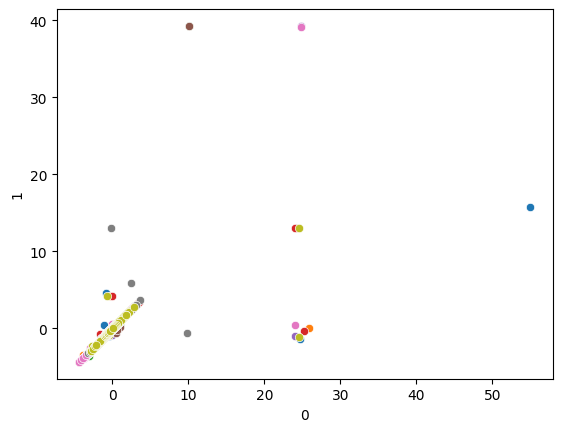

In [147]:

for t in target_results.keys():
    try:
        pl_df = target_results[t].pivot(index='variable', columns='split', values='log_fc')
    except:
        continue
    # print(pl_df.corr())
    sns.scatterplot(data=pl_df, x=0, y=1)

In [148]:
pl_df.loc[(pl_df[0] - pl_df[1]).sort_values().index]


split,0,1,2
variable,,,
IL22,-0.751852,4.213890,1.083542
GNLY,-2.632509,-2.310545,-2.300849
SLC16A6,1.297579,1.330174,1.330888
LYZ,-1.151188,-1.125645,-1.140724
CDR2L,0.449775,0.473186,0.470520
...,...,...,...
VWA2,NaN,NaN,NaN
WDFY4,NaN,NaN,NaN
WDR87,NaN,NaN,NaN


In [149]:
# Dictionary to store results for each model and target
results_conf = {}

# For each model, test each target
for model_name, model in models.items():
    model_res_df = pd.DataFrame()

    # Create contrast for target vs NTC in Rest condition
    t_contrast = (model.cond(culture_condition="Rest") - model.cond(culture_condition="Stim8hr"))
    # Run the test and store results
    res_df = model.test_contrasts(t_contrast)
    res_df['contrast'] = 'Rest'

    results_conf[model_name] = res_df


Running Wald tests...
... done in 0.85 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.088287       -1.127341   0.839755 -1.342464  0.179446   
CFH              0.082714        0.363311   6.233546  0.058283  0.953523   
CFTR             0.003412        0.378446  50.277640  0.007527  0.993994   
CYP51A1          4.648801       -0.835879   0.678244 -1.232416  0.217794   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.187059        0.085398   0.825686  0.103426  0.917625   
LINC02929        0.000222        0.365778  50.277476  0.007275  0.994195   
ENSG00000285938  0.007683        0.363125  50

... done in 0.80 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098       -0.103899  50.310580 -0.002065  0.998352   
C1orf112         3.087545       -1.754630   1.625103 -1.079704  0.280274   
CFH              0.075635       -0.127560   6.757851 -0.018876  0.984940   
CFTR             0.004253       -0.106868  50.311066 -0.002124  0.998305   
CYP51A1          4.659760       -2.897506   1.163992 -2.489284  0.012800   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.176742       -3.149033   2.096660 -1.501928  0.133116   
LINC02929        0.000222       -0.103093  50.310588 -0.002049  0.998365   
ENSG00000285938  0.007219       -0.101343  50

... done in 0.84 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000098        0.364084  50.242496  0.007247  0.994218   
C1orf112         3.053736       -1.129582   0.839739 -1.345158  0.178574   
CFH              0.077580        0.366614   6.612000  0.055447  0.955782   
CFTR             0.003840        0.377756  50.242680  0.007519  0.994001   
CYP51A1          4.624748       -0.838298   0.674821 -1.242252  0.214143   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.150554        0.086818   0.828688  0.104766  0.916562   
LINC02929        0.000222        0.364918  50.242495  0.007263  0.994205   
ENSG00000285938  0.007199        0.369697  50

... done in 0.89 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.122277        1.673423   0.947860  1.765476  0.077484   
CFH              0.080774        0.560369   6.281564  0.089209  0.928916   
CFTR             0.003826        0.543850  50.324800  0.010807  0.991378   
CYP51A1          4.684159       -1.139847   0.873550 -1.304844  0.191946   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.213390        0.844393   0.991171  0.851914  0.394262   
LINC02929        0.000223        0.546119  50.324907  0.010852  0.991342   
ENSG00000285938  0.007705        0.540118  50

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
TSPAN6           0.000000             NaN        NaN       NaN       NaN   
C1orf112         3.099589       -1.132130   0.842211 -1.344235  0.178872   
CFH              0.078476        0.366430   6.416168  0.057110  0.954457   
CFTR             0.004006        0.377400  50.265877  0.007508  0.994009   
CYP51A1          4.654560       -0.838698   0.679502 -1.234284  0.217097   
...                   ...             ...        ...       ...       ...   
ARHGAP11B        2.186436        0.084108   0.826601  0.101751  0.918954   
LINC02929        0.000222        0.364540  50.265673  0.007252  0.994214   
ENSG00000285938  0.008701        0.363611  50

... done in 1.24 seconds.



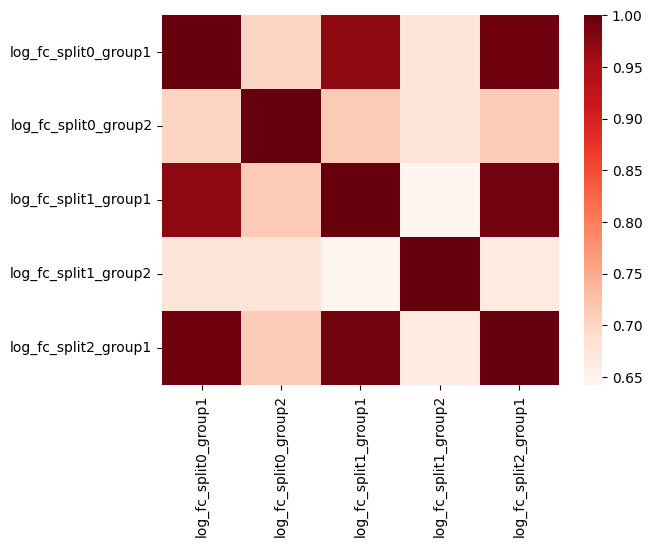

In [150]:
merged_rest_effects = pd.concat([x.set_index('variable')[['log_fc']].rename({'log_fc':f'log_fc_{k}'}, axis=1) for k,x in results_conf.items()], axis=1)
sns.heatmap(merged_rest_effects.corr(), cmap='Reds');

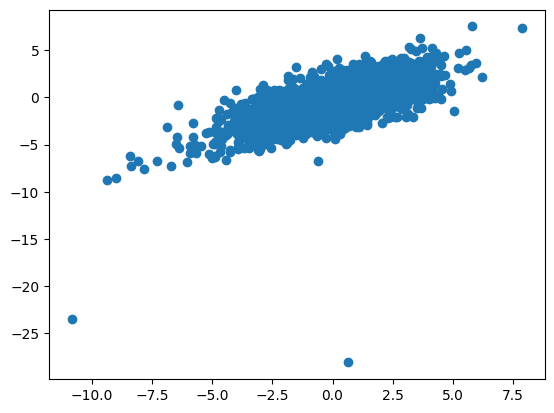

In [151]:
plt.scatter(merged_rest_effects['log_fc_split0_group1'], merged_rest_effects['log_fc_split0_group2'])

In [117]:
merged_rest_effects.loc['IL5']

log_fc_split0_group1    -9.553570
log_fc_split0_group2    -4.540675
log_fc_split1_group1   -11.225813
log_fc_split1_group2   -10.888545
log_fc_split2_group1   -11.118601
log_fc_split2_group2   -14.177022
Name: IL5, dtype: float64

In [157]:
mspert_data.adata = mspert_data.adata[mspert_data.adata.obs['culture_condition'] == 'Rest'].copy()

In [158]:
np.random.seed(321)
de_test_targets = np.random.choice(test_targets, size=10, replace=False)

# Dictionary to store models for each split
models = {}

# Fit a model for each group in splits
for i, (group1, group2) in enumerate(splits):
    print(i)
    # Fit model for group1
    pbulk_adata_group1 = mspert_data.adata[mspert_data.adata.obs['target'].isin(group1)].copy()
    model_group1 = pertpy.tl.PyDESeq2(pbulk_adata_group1, design='~ donor_id + target')
    model_group1.fit(quiet=True)
    models[f'split{i}_group1'] = model_group1
    
    # Fit model for group2
    pbulk_adata_group2 = mspert_data.adata[mspert_data.adata.obs['target'].isin(group2)].copy()
    model_group2 = pertpy.tl.PyDESeq2(pbulk_adata_group2, design='~ donor_id + target')
    model_group2.fit(quiet=True)
    models[f'split{i}_group2'] = model_group2




0


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



1


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



2


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [164]:
models

{'split0_group1': <pertpy.tools._differential_gene_expression._pydeseq2.PyDESeq2 at 0x7f4e896d99d0>,
 'split0_group2': <pertpy.tools._differential_gene_expression._pydeseq2.PyDESeq2 at 0x7f4e896dbb00>,
 'split1_group1': <pertpy.tools._differential_gene_expression._pydeseq2.PyDESeq2 at 0x7f4e8bbcc5f0>,
 'split1_group2': <pertpy.tools._differential_gene_expression._pydeseq2.PyDESeq2 at 0x7f4e778132f0>,
 'split2_group1': <pertpy.tools._differential_gene_expression._pydeseq2.PyDESeq2 at 0x7f4e8975e870>,
 'split2_group2': <pertpy.tools._differential_gene_expression._pydeseq2.PyDESeq2 at 0x7f4e8975d640>}

In [166]:

# Dictionary to store results for each model and target
results = {}

# For each model, test each target
for model_name, model in models.items():
    results[model_name] = {}
    model_res_df = pd.DataFrame()
    for t in de_test_targets:
        # Check if target is in the model's design matrix
        if f'target[T.{t}]' in model.design.columns:
            # Create contrast for target vs NTC in Rest condition
            t_contrast = (model.cond(target=t) - 
                          model.cond(target="NTC"))
            # Run the test and store results
            res_df = model.test_contrasts(t_contrast)
            res_df['contrast'] = t
            model_res_df = pd.concat([model_res_df, res_df])
    
    results[model_name] = model_res_df


Running Wald tests...
... done in 0.57 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172       -0.135047   0.679972 -0.198606  0.842571   
CFH              0.106265       -0.023127   3.230585 -0.007159  0.994288   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491       -1.002485   0.858814 -1.167290  0.243093   
HS3ST1           0.001666        0.345565  27.541519  0.012547  0.989989   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952       -0.352315   0.780

... done in 0.59 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172        0.360683   0.590656  0.610648  0.541433   
CFH              0.106265       -0.090241   3.203809 -0.028167  0.977529   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491       -0.976022   0.899013 -1.085659  0.277630   
HS3ST1           0.001666        0.292935  27.536423  0.010638  0.991512   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952       -1.135876   0.926

... done in 0.63 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172        1.093660   0.517310  2.114131  0.034504   
CFH              0.106265        0.501543   2.969960  0.168872  0.865897   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491        0.517628   0.571334  0.905999  0.364936   
HS3ST1           0.001666        0.026861  27.548559  0.000975  0.999222   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952        0.871397   0.567

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172        0.241313   0.538695  0.447958  0.654183   
CFH              0.106265       -0.016074   2.775178 -0.005792  0.995379   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491        0.347259   0.561929  0.617977  0.536591   
HS3ST1           0.001666        0.359910  23.856391  0.015087  0.987963   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952        0.275171   0.579

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172       -0.361285   0.527236 -0.685244  0.493190   
CFH              0.106265       -0.613993   2.795283 -0.219653  0.826141   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491        0.069118   0.508528  0.135919  0.891886   
HS3ST1           0.001666       -0.225844  23.871413 -0.009461  0.992451   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952       -0.909744   0.627

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172        0.485162   0.600111  0.808454  0.418829   
CFH              0.106265       -0.005339   3.212046 -0.001662  0.998674   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491       -1.139771   0.931886 -1.223080  0.221299   
HS3ST1           0.001666        0.363346  27.536459  0.013195  0.989472   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952       -0.154922   0.743

... done in 0.60 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172       -0.181906   0.577586 -0.314941  0.752806   
CFH              0.106265       -0.904811   3.231618 -0.279987  0.779488   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491       -0.894140   0.685376 -1.304598  0.192030   
HS3ST1           0.001666       -0.535803  27.541671 -0.019454  0.984479   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952       -0.284238   0.628

... done in 0.63 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.162172        0.451086   0.588056  0.767081  0.443033   
CFH              0.106265        0.878679   2.945482  0.298314  0.765463   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.590491        0.655742   0.607308  1.079753  0.280252   
HS3ST1           0.001666        0.380908  27.546490  0.013828  0.988967   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441952        0.187405   0.668

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.189226        0.332866   0.531974  0.625719  0.531500   
CFH              0.110367       -1.108396   3.304961 -0.335374  0.737343   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.585595       -0.506631   0.597268 -0.848248  0.396300   
HS3ST1           0.001648       -0.745607  27.522022 -0.027091  0.978387   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.393649       -0.712760   0.677

... done in 0.64 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.189226       -0.558253   0.572645 -0.974867  0.329626   
CFH              0.110367       -1.381919   3.314730 -0.416903  0.676750   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.585595        0.041137   0.524482  0.078434  0.937483   
HS3ST1           0.001648       -0.985868  27.534761 -0.035804  0.971438   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.393649       -0.096029   0.565

... done in 0.59 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.128074       -0.150164   0.681051 -0.220488  0.825491   
CFH              0.111681       -0.021847   3.320090 -0.006580  0.994750   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.581250       -1.013096   0.858955 -1.179452  0.238218   
HS3ST1           0.001608        0.345474  27.566922  0.012532  0.990001   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.419642       -0.354076   0.785

... done in 0.66 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.128074        0.368349   0.591222  0.623031  0.533264   
CFH              0.111681       -0.087629   3.290782 -0.026628  0.978756   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.581250       -0.962800   0.898051 -1.072099  0.283676   
HS3ST1           0.001608        0.298928  27.561738  0.010846  0.991346   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.419642       -1.128977   0.930

... done in 0.64 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.128074        0.493690   0.599420  0.823612  0.410160   
CFH              0.111681        0.002125   3.300111  0.000644  0.999486   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.581250       -1.125294   0.930414 -1.209455  0.226488   
HS3ST1           0.001608        0.369436  27.561361  0.013404  0.989305   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.419642       -0.143128   0.748

... done in 0.60 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.215790        0.341121   0.529674  0.644021  0.519562   
CFH              0.105076       -1.111939   3.216140 -0.345737  0.729540   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.592534       -0.498423   0.596114 -0.836119  0.403088   
HS3ST1           0.001671       -0.747987  27.496558 -0.027203  0.978298   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.411313       -0.710172   0.670

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.215790        1.091685   0.534895  2.040932  0.041258   
CFH              0.105076        0.524311   2.971931  0.176421  0.859963   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.592534        0.529613   0.561997  0.942376  0.346000   
HS3ST1           0.001671        0.041647  27.510526  0.001514  0.998792   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.411313        0.877323   0.576

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.215790        0.228012   0.551325  0.413571  0.679188   
CFH              0.105076       -0.026857   2.778847 -0.009665  0.992289   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.592534        0.337328   0.556306  0.606370  0.544269   
HS3ST1           0.001671        0.350994  23.823636  0.014733  0.988245   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.411313        0.266744   0.586

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.215790       -0.372966   0.542311 -0.687735  0.491620   
CFH              0.105076       -0.611784   2.796689 -0.218753  0.826842   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.592534        0.064139   0.500749  0.128087  0.898080   
HS3ST1           0.001671       -0.226260  23.838100 -0.009492  0.992427   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.411313       -0.917681   0.635

... done in 0.62 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.215790       -0.571052   0.570448 -1.001060  0.316798   
CFH              0.105076       -1.389030   3.223994 -0.430841  0.666584   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.592534        0.023092   0.524083  0.044062  0.964855   
HS3ST1           0.001671       -0.996530  27.509300 -0.036225  0.971103   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.411313       -0.107966   0.557

... done in 0.62 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.215790       -0.169244   0.593078 -0.285365  0.775364   
CFH              0.105076       -0.892346   3.239010 -0.275500  0.782932   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.592534       -0.893838   0.678365 -1.317636  0.187626   
HS3ST1           0.001671       -0.528473  27.504363 -0.019214  0.984670   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.411313       -0.280620   0.636

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.215790        0.426613   0.604467  0.705768  0.480333   
CFH              0.105076        0.855314   2.947045  0.290228  0.771642   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.592534        0.630590   0.600551  1.050020  0.293709   
HS3ST1           0.001671        0.360907  27.508370  0.013120  0.989532   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.411313        0.173179   0.676

... done in 0.63 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.154278        0.239652   0.540931  0.443037  0.657739   
CFH              0.105877       -0.017324   2.805879 -0.006174  0.995074   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.600592        0.350091   0.561578  0.623406  0.533018   
HS3ST1           0.001658        0.358626  23.867401  0.015026  0.988012   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441730        0.276022   0.582

... done in 0.65 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.154278       -0.559366   0.558071 -1.002321  0.316189   
CFH              0.105877       -1.356158   3.257292 -0.416345  0.677157   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.600592        0.060746   0.531829  0.114220  0.909063   
HS3ST1           0.001658       -0.971800  27.560726 -0.035260  0.971872   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441730       -0.094928   0.553

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.154278       -0.180274   0.580178 -0.310721  0.756012   
CFH              0.105877       -0.900694   3.269735 -0.275464  0.782960   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.600592       -0.894148   0.684771 -1.305764  0.191633   
HS3ST1           0.001658       -0.532483  27.554776 -0.019325  0.984582   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441730       -0.283854   0.632

... done in 0.63 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.154278        0.448390   0.589986  0.760000  0.447254   
CFH              0.105877        0.868781   2.981247  0.291415  0.770734   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.600592        0.653579   0.606943  1.076836  0.281553   
HS3ST1           0.001658        0.365131  27.558550  0.013249  0.989429   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.441730        0.181055   0.672

... done in 0.63 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.196364        0.327955   0.529432  0.619448  0.535622   
CFH              0.110823       -1.115754   3.270881 -0.341117  0.733015   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.575217       -0.506100   0.597719 -0.846719  0.397152   
HS3ST1           0.001656       -0.752362  27.509624 -0.027349  0.978181   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.393292       -0.716103   0.674

... done in 0.64 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.196364       -0.162478   0.696981 -0.233118  0.815670   
CFH              0.110823       -0.007525   3.289091 -0.002288  0.998175   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.575217       -0.997578   0.852857 -1.169690  0.242126   
HS3ST1           0.001656        0.355471  27.516580  0.012918  0.989693   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.393292       -0.348590   0.790

... done in 0.66 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.196364        0.370972   0.604890  0.613288  0.539686   
CFH              0.110823       -0.093284   3.260461 -0.028611  0.977175   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.575217       -0.971225   0.895479 -1.084587  0.278105   
HS3ST1           0.001656        0.301346  27.511165  0.010954  0.991260   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.393292       -1.126758   0.934

... done in 0.62 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.196364        1.082150   0.534869  2.023205  0.043052   
CFH              0.110823        0.525143   3.032391  0.173178  0.862512   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.575217        0.532088   0.563347  0.944512  0.344908   
HS3ST1           0.001656        0.044137  27.524015  0.001604  0.998721   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.393292        0.881569   0.580

... done in 0.63 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
                 baseMean  log2FoldChange      lfcSE      stat    pvalue  \
C1orf112         3.196364       -0.368039   0.541127 -0.680134  0.496419   
CFH              0.110823       -0.612897   2.846294 -0.215332  0.829509   
CFTR             0.000000             NaN        NaN       NaN       NaN   
CYP51A1          2.575217        0.065988   0.501630  0.131546  0.895343   
HS3ST1           0.001656       -0.230120  23.849455 -0.009649  0.992301   
...                   ...             ...        ...       ...       ...   
ENSG00000284797  0.000000             NaN        NaN       NaN       NaN   
CCDC39           0.000000             NaN        NaN       NaN       NaN   
ARHGAP11B        2.393292       -0.919045   0.638

... done in 0.62 seconds.



In [167]:
# Create a dictionary to store concatenated results for each target
target_results = {}

for t in de_test_targets:
    # Initialize an empty DataFrame to store all results for this target
    all_results_for_target = pd.DataFrame()
    
    for i in range(3):  # Assuming 3 splits based on previous code
        for group in ['group1', 'group2']:
            model_key = f'split{i}_{group}'
            if model_key in results and not results[model_key].empty:
                # Filter results for this target
                target_df = results[model_key][results[model_key].contrast == t]
                if not target_df.empty:
                    # Add columns for split and group
                    target_df = target_df.copy()
                    target_df['split'] = i
                    target_df['group'] = group
                    # Concatenate to the results for this target
                    all_results_for_target = pd.concat([all_results_for_target, target_df])
    
    # Store the concatenated results for this target
    target_results[t] = all_results_for_target
    
    # Print summary
    if not all_results_for_target.empty:
        print(f"Target {t}: Found in {len(all_results_for_target)} model(s)")
    else:
        print(f"Target {t}: No results found")

Target ENSG00000139722: Found in 15210 model(s)
Target ENSG00000134326: Found in 15210 model(s)
Target ENSG00000177508: Found in 15210 model(s)
Target ENSG00000123427: Found in 15210 model(s)
Target ENSG00000151067: Found in 15210 model(s)
Target ENSG00000169379: Found in 15210 model(s)
Target ENSG00000189195: Found in 15210 model(s)
Target ENSG00000121060: Found in 15210 model(s)
Target ENSG00000125375: Found in 15210 model(s)
Target ENSG00000129514: Found in 15210 model(s)


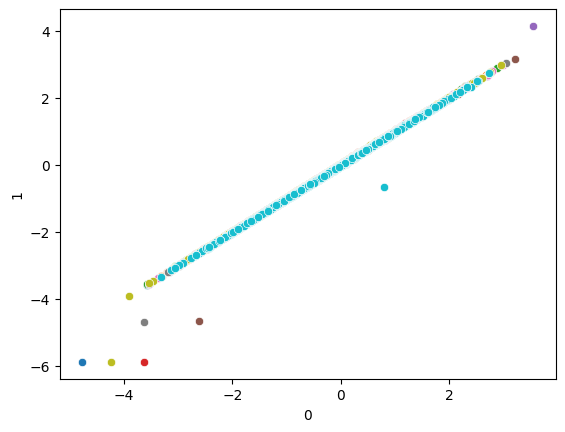

In [168]:
for t in target_results.keys():
    try:
        pl_df = target_results[t].pivot(index='variable', columns='split', values='log_fc')
    except:
        continue
    # print(pl_df.corr())
    sns.scatterplot(data=pl_df, x=0, y=1)

In [170]:
pl_df.loc[(pl_df[0] - pl_df[1]).sort_values().index]


split,0,1,2
variable,,,
CR1,2.333308,2.368718,2.368183
LAPTM4B,1.696335,1.720153,1.707048
TTC8,2.727511,2.750855,2.700247
HOMER2,1.434073,1.455993,1.424781
PI16,1.333857,1.353548,1.333655
...,...,...,...
ZNF534,0.393509,NaN,NaN
ZNF593OS,NaN,NaN,NaN
ZNF723,NaN,NaN,NaN


In [172]:
pbulk_adata.obs['donor_id']

CE0008162_Rest_ABCB6-1       CE0008162
CE0008162_Rest_ABCB6-2       CE0008162
CE0008162_Rest_ALG10B-2      CE0008162
CE0008162_Rest_ALOX5AP-1     CE0008162
CE0008162_Rest_ALOX5AP-2     CE0008162
                               ...    
CE0010866_Stim8hr_NTC-986    CE0010866
CE0010866_Stim8hr_NTC-987    CE0010866
CE0010866_Stim8hr_NTC-988    CE0010866
CE0010866_Stim8hr_NTC-989    CE0010866
CE0010866_Stim8hr_NTC-991    CE0010866
Name: donor_id, Length: 2139, dtype: category
Categories (2, object): ['CE0008162', 'CE0010866']

In [173]:
# Dictionary to store results for each model and target
results_conf = {}

# For each model, test each target
for model_name, model in models.items():
    model_res_df = pd.DataFrame()

    # Create contrast for target vs NTC in Rest condition
    t_contrast = (model.cond(donor_id="CE0008162") - model.cond(donor_id="CE0010866"))
    # Run the test and store results
    res_df = model.test_contrasts(t_contrast)
    res_df['contrast'] = 'CE0010866'

    results_conf[model_name] = res_df


Running Wald tests...
... done in 0.64 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange     lfcSE      stat        pvalue  \
C1orf112         3.162172       -0.374234  0.063661 -5.878515  4.139631e-09   
CFH              0.106265        0.092410  0.326836  0.282743  7.773741e-01   
CFTR             0.000000             NaN       NaN       NaN           NaN   
CYP51A1          2.590491        0.404151  0.067288  6.006305  1.897993e-09   
HS3ST1           0.001666        0.135807  2.921237  0.046490  9.629201e-01   
...                   ...             ...       ...       ...           ...   
ENSG00000284797  0.000000             NaN       NaN       NaN           NaN   
CCDC39           0.000000             NaN       NaN       NaN           NaN   
ARHGAP11B        2.441

... done in 1.00 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange     lfcSE      stat        pvalue  \
C1orf112         3.189226       -0.356397  0.065482 -5.442692  5.248131e-08   
CFH              0.110367       -0.029217  0.337677 -0.086524  9.310501e-01   
CFTR             0.000000             NaN       NaN       NaN           NaN   
CYP51A1          2.585595        0.404652  0.066695  6.067214  1.301477e-09   
HS3ST1           0.001648        0.070310  2.921717  0.024065  9.808010e-01   
...                   ...             ...       ...       ...           ...   
ENSG00000284797  0.000000             NaN       NaN       NaN           NaN   
CCDC39           0.000000             NaN       NaN       NaN           NaN   
ARHGAP11B        2.393

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange     lfcSE      stat        pvalue  \
C1orf112         3.128074       -0.346434  0.063714 -5.437332  5.408422e-08   
CFH              0.111681        0.067324  0.336309  0.200184  8.413363e-01   
CFTR             0.000000             NaN       NaN       NaN           NaN   
CYP51A1          2.581250        0.422805  0.067242  6.287811  3.219725e-10   
HS3ST1           0.001608        0.124983  2.920278  0.042798  9.658622e-01   
...                   ...             ...       ...       ...           ...   
ENSG00000284797  0.000000             NaN       NaN       NaN           NaN   
CCDC39           0.000000             NaN       NaN       NaN           NaN   
ARHGAP11B        2.419

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange     lfcSE      stat        pvalue  \
C1orf112         3.215790       -0.384176  0.065232 -5.889347  3.877247e-09   
CFH              0.105076       -0.004233  0.328129 -0.012901  9.897071e-01   
CFTR             0.000000             NaN       NaN       NaN           NaN   
CYP51A1          2.592534        0.385362  0.066663  5.780735  7.437489e-09   
HS3ST1           0.001671        0.081145  2.922676  0.027764  9.778504e-01   
...                   ...             ...       ...       ...           ...   
ENSG00000284797  0.000000             NaN       NaN       NaN           NaN   
CCDC39           0.000000             NaN       NaN       NaN           NaN   
ARHGAP11B        2.411

... done in 0.61 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
                 baseMean  log2FoldChange     lfcSE      stat        pvalue  \
C1orf112         3.154278       -0.390228  0.063931 -6.103910  1.035047e-09   
CFH              0.105877        0.038623  0.330690  0.116796  9.070218e-01   
CFTR             0.000000             NaN       NaN       NaN           NaN   
CYP51A1          2.600592        0.418118  0.067304  6.212404  5.217990e-10   
HS3ST1           0.001658        0.086594  2.920711  0.029648  9.763477e-01   
...                   ...             ...       ...       ...           ...   
ENSG00000284797  0.000000             NaN       NaN       NaN           NaN   
CCDC39           0.000000             NaN       NaN       NaN           NaN   
ARHGAP11B        2.441

... done in 0.65 seconds.



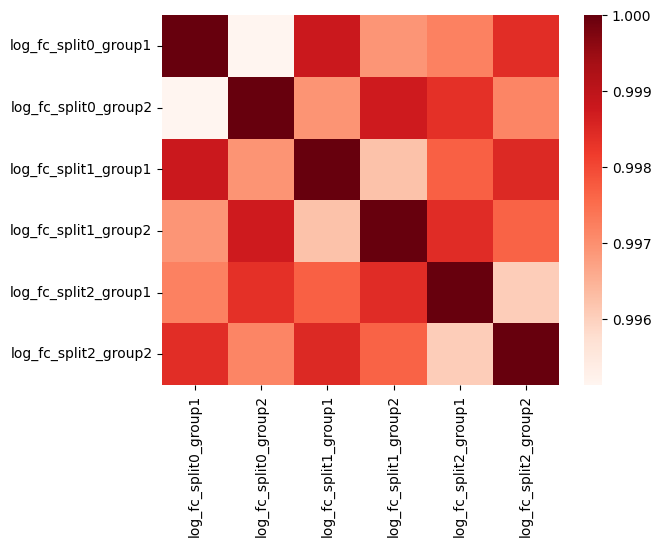

In [174]:
merged_rest_effects = pd.concat([x.set_index('variable')[['log_fc']].rename({'log_fc':f'log_fc_{k}'}, axis=1) for k,x in results_conf.items()], axis=1)
sns.heatmap(merged_rest_effects.corr(), cmap='Reds');

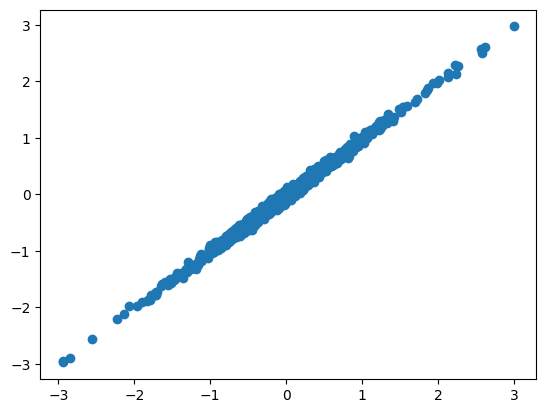

In [175]:
plt.scatter(merged_rest_effects['log_fc_split0_group1'], merged_rest_effects['log_fc_split0_group2'])

In [ ]:
merged_rest_effects.loc['IL5']

log_fc_split0_group1    -9.553570
log_fc_split0_group2    -4.540675
log_fc_split1_group1   -11.225813
log_fc_split1_group2   -10.888545
log_fc_split2_group1   -11.118601
log_fc_split2_group2   -14.177022
Name: IL5, dtype: float64

## Optimized design

In [63]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'
adata = sc.read_h5ad(f'{datadir}/tmp/{experiment_name}_merged.gex.h5ad', backed=True)
adata.obs = pd.read_csv(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index_col=0)

In [61]:
adata_smol = adata[adata.obs['QC_mask']].to_memory()
adata_smol.obs['perturbed_gene_id'] = np.where(adata_smol.obs['perturbed_gene_name'] == 'NTC', 'NTC', adata_smol.obs['perturbed_gene_id'] )

condition_col = 'culture_condition'
sgrna_col = 'guide_id'

mspert_data = MultistatePerturbSeqDataset(
    adata_smol,
    state_col=condition_col,
    sample_cols = ['donor_id'],
    target_col='perturbed_gene_id',
    perturbation_type = 'CRISPRi',
    sgrna_col = sgrna_col,
    control_level='NTC'
)
mspert_data.pseudobulk()

In [ ]:
mspert_data

In [ ]:
np.random.seed(432)
sample_perturbations = np.random.choice(passing_genes_both, size=100, replace=False).tolist()
if 'NTC' not in sample_perturbations:
    sample_perturbations.append('NTC')



/tmp/ipykernel_523673/4138211806.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smol.obs['perturbed_gene_id'] = np.where(adata_smol.obs['perturbed_gene_name'] == 'NTC', 'NTC', adata_smol.obs['perturbed_gene_id'] )


ValueError: To copy an AnnData object in backed mode, pass a filename: `.copy(filename='myfilename.h5ad')`. To load the object into memory, use `.to_memory()`.

In [36]:
mspert_data.adata.write_h5ad('./test_pseudobulk.h5ad')

In [7]:
adata = sc.read_h5ad('./test_pseudobulk.h5ad')

In [9]:
condition_col = 'culture_condition'
cond = 'Rest'
adata_cond = adata[adata.obs[condition_col] == cond][:, adata.X.sum(0) >= 3].copy()

In [15]:
adata_cond

AnnData object with n_obs × n_vars = 1639 × 8776
    obs: 'sample_id', 'donor_id', 'culture_condition', 'sgrna', 'target'
    var: 'gene_ids', 'gene_name', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'count_nonzero'

,sgrna,perturbed_gene_expr,perturbed_gene_mean_ntc,perturbed_gene_std_ntc,n_ntc_cells,perturbed_gene_expr_std,n_perturbed_cells,t_statistic,p_value,adj_p_value,signif_knockdown
0,ABHD4-1,0.0,1.455322,1.981888,1287.0,NaN,1,NaN,NaN,NaN,False
43,DDX43-2,0.0,0.101787,0.387916,1287.0,NaN,1,NaN,NaN,NaN,False
49,DXO-2,0.0,1.185703,1.790204,1287.0,NaN,1,NaN,NaN,NaN,False
50,EFEMP2-1,0.0,0.043512,0.222236,1287.0,NaN,1,NaN,NaN,NaN,False
52,EHBP1-1,0.0,3.525253,4.609282,1287.0,NaN,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
84,LEPROTL1-1,1.0,50.550117,54.654502,1287.0,0.000000,2,-32.524304,7.924929e-170,1.109490e-167,True
85,LEPROTL1-2,41.5,50.550117,54.654502,1287.0,3.535534,2,-3.091282,9.784694e-02,1.342997e-01,False
86,LMAN2L-1,0.0,1.082362,1.569738,1287.0,0.000000,2,-24.736288,8.070206e-111,4.035103e-110,True
32,CD44-1,4.0,26.996115,29.945859,1287.0,2.828427,2,-10.610954,2.739289e-02,4.620487e-02,True


In [ ]:


# Alternatively, we can use a relative import
# from ..preprocess.qc_plots import plot_gene_expression, plot_qc_metrics, plot_cell_counts

# adata_cond = mspert_data.adata[mspert_data.adata.obs[condition_col] == cond][:, mspert_data.adata.X.sum(0) >= 3].copy()

model = pertpy.tl.PyDESeq2(adata_cond, design='~ donor_id + target')
model.fit(quiet=True)

In [ ]:
all_targets = adata.obs['target'].unique().tolist()
all_targets.remove('NTC')

all_res_df = pd.DataFrame()
from tqdm import tqdm
for t in tqdm(all_targets, desc="Testing targets"):
    t_contrast = (model.cond(target = t) - model.cond(target = "NTC")) 
    res_df = model.test_contrasts(t_contrast)
    res_df[condition_col] = cond
    res_df['contrast'] = t
    all_res_df = pd.concat([all_res_df, res_df])


In [27]:
# Get unique contrasts
unique_contrasts = all_res_df['contrast'].unique()
n_contrasts = len(unique_contrasts)

# Plot histogram for each contrast
for i, contrast in enumerate(unique_contrasts):
    contrast_data = all_res_df[all_res_df['contrast'] == contrast]
    print(f"test {contrast}: ", sum(contrast_data['adj_p_value'] < 0.1));
# sns.scatterplot(data=contrast_data.dropna(), x='baseMean', y='log_fc');
# plt.xscale('log')

test ENSG00000100439:  0
test ENSG00000196177:  0
test ENSG00000182827:  0
test ENSG00000196839:  1
test ENSG00000155966:  1
test ENSG00000164252:  0
test ENSG00000106992:  0
test ENSG00000013523:  0
test ENSG00000151136:  1
test ENSG00000154640:  0
test ENSG00000139637:  0
test ENSG00000140688:  0
test ENSG00000204564:  0
test ENSG00000177875:  0
test ENSG00000107771:  1
test ENSG00000198087:  1
test ENSG00000026508:  1
test ENSG00000079335:  3
test ENSG00000013441:  0
test ENSG00000117519:  0
test ENSG00000272886:  0
test ENSG00000080007:  0
test ENSG00000278535:  0
test ENSG00000100246:  1
test ENSG00000204348:  0
test ENSG00000172638:  110
test ENSG00000115504:  0
test ENSG00000173812:  5
test ENSG00000185104:  0
test ENSG00000213185:  0
test ENSG00000217128:  0
test ENSG00000170122:  26
test ENSG00000089327:  1
test ENSG00000107485:  47
test ENSG00000136574:  1
test ENSG00000176928:  0
test ENSG00000114450:  0
test ENSG00000147099:  0
test ENSG00000290292:  0
test ENSG00000068079:

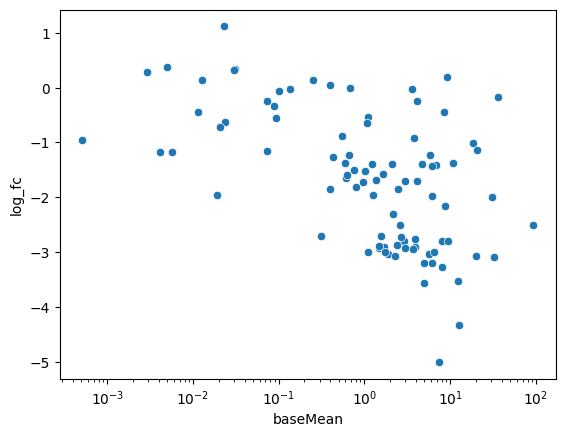

In [37]:
sns.scatterplot(
    data=all_res_df[all_res_df['contrast'] == all_res_df['variable']],
    x='baseMean', y='log_fc'
    );
plt.xscale('log')

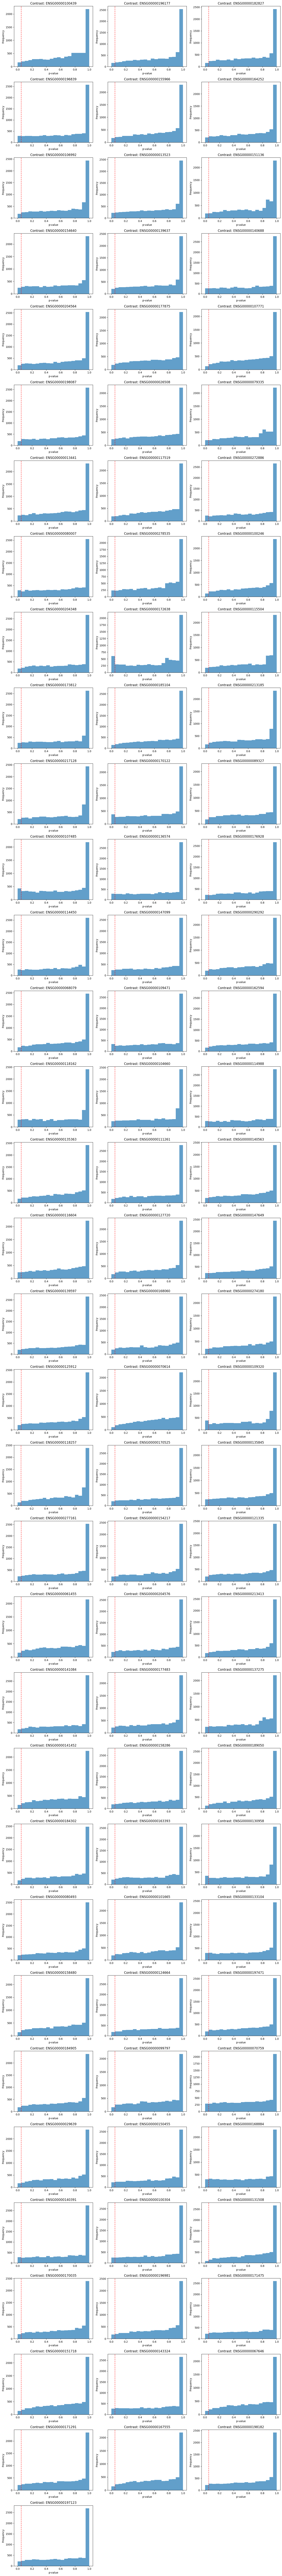

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast,culture_condition
0,ENSG00000130713,2.589231,1.431689,0.426041,3.360446,0.000778,0.996732,ENSG00000100439,Rest
1,ENSG00000197375,0.399994,2.495871,0.750518,3.325531,0.000883,0.996732,ENSG00000100439,Rest
2,ENSG00000106123,2.166812,3.535633,1.153162,3.066033,0.002169,0.996732,ENSG00000100439,Rest
3,ENSG00000071073,15.983463,-1.110418,0.363285,-3.056605,0.002239,0.996732,ENSG00000100439,Rest
4,ENSG00000123297,3.309588,1.162352,0.382599,3.038045,0.002381,0.996732,ENSG00000100439,Rest
...,...,...,...,...,...,...,...,...,...
8771,ENSG00000266265,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000197123,Rest
8772,ENSG00000276070,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000197123,Rest
8773,ENSG00000277363,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000197123,Rest
8774,ENSG00000283267,0.000000,NaN,NaN,NaN,NaN,NaN,ENSG00000197123,Rest


In [ ]:
# Plot p-value histograms for each contrast
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Get unique contrasts
unique_contrasts = all_res_df['contrast'].unique()
n_contrasts = len(unique_contrasts)

# Calculate grid dimensions
n_cols = 3
n_rows = (n_contrasts + n_cols - 1) // n_cols  # Ceiling division

# Create figure with subplots
fig = plt.figure(figsize=(15, n_rows * 4))
gs = GridSpec(n_rows, n_cols, figure=fig)

# Plot histogram for each contrast
for i, contrast in enumerate(unique_contrasts):
    row, col = i // n_cols, i % n_cols
    ax = fig.add_subplot(gs[row, col])
    
    # Filter data for this contrast
    contrast_data = all_res_df[all_res_df['contrast'] == contrast]
    
    # Plot histogram of p-values
    ax.hist(contrast_data['p_value'].dropna(), bins=20, alpha=0.7)
    ax.set_title(f'Contrast: {contrast}')
    ax.set_xlabel('p-value')
    ax.set_ylabel('Frequency')
    
    # Add vertical line at p=0.05 for reference
    ax.axvline(x=0.05, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
